# Python implementation of RICE-2010 - Baseline run

This code is an implementation of William Nordhaus' RICE model. It is based, on the one hand, on the Python implementation of DICE-2016 by Hazem Krichene (as far as code main structure is concerned) and, on the other hand, on RICE-2010 Excel sheet (as far as calibration, parameters and so on are concerned).\
It proceeds in the following way : first, importation of packages and initialization of model parameters ; second, declaration of model functions, both for exogenous and endogenous variables ; third, definition of optimization function and of system computation function ; last, model lauching and graphs plotting. 

### 1. Package importation and parameters initialization

#### Package importation

In [1]:
import numpy as np
import time
import math
from numba import njit,guvectorize,float64
import scipy.optimize as opt 
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Model parameters setting

In [137]:
# Time and regions settings

t = np.arange(1, 101) # number of periods
NT = len(t)
tstep = math.floor(500/NT) # number of years per period (set to cover total time span of 500 years)
c = np.arange(0, 12) # number of regions/countries
NC = len(c)
COUNTRIES = np.array(["US", "OECD Europe", "Japan", "Russia", "Eurasia", "China", "India", "Middle East",
                     "Sub-Sahara Africa", "Latin America", "Other high income", "Other developping"])

# Preferences

alpha = 1.5 # social welfare function parameter
rho = 0.015 # rate of social time preference (per YEAR)
rr = 1/((1+rho)**(tstep*(t-1))) # discount factor
weights = np.full(NC,1) # can be used to weight countries in the welfare function

#### Initial values of parameters

In [3]:
# Population

pop0W = 6410 # initial population, in millions
pop0 = np.array([296.84, 490.08, 127.77, 143.15, 155.94, 1304.50, 1094.58, 412.77, 763.51, 555.38, 129.17, 937.20])
l = np.zeros(shape = (NT, NC)) # labor force, equal to population
l[0] = pop0
gpop = 0.134 # growth rate of population
popasymW = 8699 # asymptotic population, in millions
popasym = np.array([477.76, 520.79, 93.41, 104.86, 136.79, 1297.67, 1399.41, 835.22, 1573.27, 684.95, 150.17, 1425.17]) 

# Production technology

gama = 0.300 # capital elasticity in production function
dk = 0.100 # depreciation rate of capital (per YEAR)
q0W = 55.37 # initial gross output, in trillion $
q0 = np.array([12.3979002, 13.03105748, 3.870283785, 1.697956695, 0.807335054, 5.333232743,
               2.440831513, 3.480103349, 1.300530136, 4.558476252, 3.84204975, 2.619188737])
k0W = 180 # initial capital value, in trillion $
k0 = np.array([22.85109974, 23.30227532, 7.133485459, 2.787107432, 1.362472206, 9.260935035,
               4.119188282, 5.416068489, 2.134752445, 7.692961135, 6.87039415, 4.420186931])
a0W = 5.115 # initial level of total factor productivity
a0 = np.array([11.34769536, 8.347821548, 9.062435157, 4.867730775, 2.70196943, 2.2708227,
               1.498373969, 3.894860836, 1.25125954, 3.730597775, 9.029344259, 1.754904331])
al = np.zeros(shape = (NT, NC)) # total factor productivity
al[0] = a0
gtfp0 = 0.0488 # initial growth rate of TFP (per PERIOD)
deltatfp = 0.005 # decline rate of TFP (per YEAR)
gtfp = gtfp0 * np.exp(-deltatfp*tstep*(t-1))

# Emissions

e0W = 7.91 # industrial emissions, GtC (per YEAR)
e0 = np.array([1.662133455, 1.146050619, 0.369965926, 0.431236182, 0.256666293, 1.600741128,
               0.40515159, 0.58967496, 0.191377084, 0.412272399, 0.541778261, 0.363952103]) * 3.666
miu0W = 0.2 # initial abatement/control rate
miu0 = np.full(NC,miu0W)
limmiu  = 1.0 # upper limit on abatement/control rate after 2150 (can be set to 1.2)
sig0W = e0W/(q0W*(1-miu0W)) # initial carbon intensity of output, in kgCO2/$
sig0 = e0/(q0*(1-miu0))
sigma = np.zeros(shape=(NT,NC)) # carbon intensity
sigma[0] = sig0
gsigma0 = -0.0125 # initial growth of sigma (per PERIOD)
deltasig = -0.009577 # decline rate of decarbonization (per YEAR)
gsig = np.zeros(NT) # growth of sigma
gsig[0] = gsigma0
etree0 = 1.6 * 3.666 # initial carbon emissions from land use, in GtC (per PERIOD)
deltatree = 0.01839 # decline rate of land use emissions (per YEAR)
etree = etree0*(1-deltatree)**(tstep*(t-1))
cumetree = np.zeros(NT) # cumulative emissions from land use
cumetree[0] = 100

# Carbon cycle

# initial conditions
mat0 = 829 # initial carbon concentration in the atmosphere, in GtC
mu0 = 460 # in upper oceans
ml0 = 1740 # in deep oceans
mateq = 588 # equilibrium carbon concentration in the atmosphere, in GtC
muoeq = 360 # in upper oceans
mdoeq = 1720 # in deep oceans
# flow paramaters (phi coefficients)
b12 = 0.12
b23 = 0.007
b11 = 1 - b12
b21 = b12*mateq/muoeq
b22 = 1 - b21 - b23
b32 = b23*muoeq/mdoeq
b33 = 1 - b32

# Climate model

teq = 3.2 # equilibrium temperature impact of CO2 doubling, in °C
feq = 3.8 # equilibrium forcing impact of CO2 doubling
fex0 = 0.5 # initial forcings of non-CO2 greenhouse gases, in Wm-2
fex1 = 1.0 # 2100 forcings
forcoth = np.full(NT,fex0) # exogenous radiative forcing
tocean0 = 0.0068 # initial temperature of deep oceans, in °C
tatm0 = 0.83 # initial atmospheric temperature, in °C
# temperature equation coefficients
c1 = 0.1005
c2 = feq/teq
c3 = 0.088
c4 = 0.025

# Damages

a1 = np.array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0785, 0.4385, 0.2780, 0.3410, 0.0609, 0.0000, 0.1755])
# damage intercept coefficient
a2 = np.array([0.1414, 0.1591, 0.1617, 0.1151, 0.1305, 0.1259, 0.1689, 0.1586, 0.1983, 0.1345, 0.1564, 0.1734])
# damage second term coefficient
a3 = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# damage second term exponent

# Abatement cost

cost1 = np.zeros(shape=(NT,NC))
expcost2 = 2.8 # exponent of abatement cost function
pback = 1260 # initial cost of backstop technology in $/tCO2
gpback = 0.025 # initial decline of backstop cost (per YEAR)
pbacktime = pback * (1-gpback)**(tstep*(t-1)) # backstop price (per YEAR)

# Saving rate and scaling

optlrsav = (dk+0.004) / (dk + 0.004*alpha + rho) * gama # optimal long-run saving rate, used for transversality
scale1 = 0.0302455265681763
scale2 = -10993.704

#### Bounds for choice variables

In [4]:
# Abatement/control rate

MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:math.floor(150/tstep)] = 1 # only useful if limmiu not equal to 1
MIU_lo[0] = min(miu0)
MIU_up[0] = min(miu0)
MIU_lo[MIU_lo==MIU_up] = 0.99999 * MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))

# Saving rate

lag = t > NT - tstep
S_lo = np.full(NT,0.1)
S_lo[lag] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))

# Arbitrary starting values for control variables

S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

### 2. Dynamics of parameters

#### Exogenous parameters

In [5]:
def InitializeForcings(iforcoth, iNT): # exogenous non CO2 forcings
    for t in range(1,iNT):
        iforcoth[t] = iforcoth[t-1]*(fex1/iforcoth[t-1])**0.1

def InitializeLabor(il,iNT): # labor force
    for i in range(1,iNT):
        il[i] = il[i-1] * (popasym/il[i-1])**gpop

def InitializeTFP(ial,iNT): # total factor productivity
    for i in range(1,iNT):
        ial[i] = ial[i-1] * (1+gtfp[i-1])
        
def InitializeGrowthSigma(igsig,iNT): # growth rate of sigma
    for i in range(1,iNT):
        igsig[i] = igsig[i-1] * ((1+deltasig)**tstep)
        
def InitializeSigma(isigma,igsig,icost1,iNT): # carbon intensity of output
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1]*tstep)
        icost1[i] = pbacktime[i] * isigma[i] / (expcost2*1000)

def InitializeCarbonTree(icumetree,iNT): # emissions from land use
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + (etree[i-1]/3.666)*tstep

#### Functions related to climate and damages

In [6]:
def fEIND(iYGROSS,iMIU,isigma,index): # industrial carbon emissions (by REGION)
    return isigma[index] * iYGROSS[index] * (1-iMIU[index])

def fWEIND(iEIND,index): # total industrial emissions
    return np.sum(iEIND[index])

def fE(iWEIND,index): # total emissions including land use emissions
    return iWEIND[index] + etree[index]
 
def fCCA(iCCA,iWEIND,index): # cumulative industrial carbon emissions
    return iCCA[index-1] + iWEIND[index-1] * tstep / 3.666

def fCCATOT(iCCA,icumetree,index): # cumulative total carbon emissions
    return iCCA[index] + icumetree[index]

def fFORC(iMAT,index): # total radiative forcings
    return feq * np.log(iMAT[index]/mateq) / np.log(2) + forcoth[index]

def fDAMFRAC(iTATM, index): # damages as a fraction of gross output (by REGION)
    return (a1*iTATM[index] + a2*np.power(iTATM[index],a3)) / 100

def fDAMAGES(iYGROSS,iDAMFRAC,index): # damages value (by REGION)
    return iYGROSS[index] * iDAMFRAC[index]

def fABATECOST(iYGROSS,iMIU,icost1,index): # total abatement cost (by REGION)
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

def fMCABATE(iMIU,index): # marginal abatement cost (by REGION)
    return pbacktime[index] * iMIU[index]**(expcost2-1)

def fCPRICE(iMIU,index): # cost of carbon, equal to MAC (by REGION)
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

def fMAT(iMAT,iMU,iE,index): # atmospheric carbon concentration
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + (iE[index-1]/3.666)*tstep

def fML(iML,iMU,index): # carbon concentration in deep oceans
    if(index == 0):
        return ml0
    else:
        return iML[index-1]*b33  + iMU[index-1]*b23

def fMU(iMAT,iMU,iML,index): # carbon concentration in upper oceans
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

def fTATM(iTATM,iFORC,iTOCEAN,index): # atmospheric temperature
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1*(iFORC[index] - c2*iTATM[index-1] - c3*(iTATM[index-1]-iTOCEAN[index-1]))

def fTOCEAN(iTATM,iTOCEAN,index): # ocean temperature
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4*(iTATM[index-1]-iTOCEAN[index-1])

#### Functions related to economic variables

In [7]:
def fWPOP(il,index): # world population
    return np.sum(il[index])

def fYGROSS(ial,il,iK,index): # gross output, no damages nor abatement costs (by REGION)
    return ial[index] * (il[index]/1000)**(1-gama) * iK[index]**gama

def fWYGROSS(iYGROSS,index): # world gross output
    return np.sum(iYGROSS[index])

def fYNET(iYGROSS,iDAMFRAC,index): # output net of damages (by REGION)
    return iYGROSS[index] * (1-iDAMFRAC[index])

def fWYNET(iYNET,index): # world output net of damages
    return np.sum(iYNET[index])

def fY(iYNET,iABATECOST,index): # net output, net of abatement costs (by REGION)
    return iYNET[index] - iABATECOST[index]

def fWY(iY,index): # world net output
    return np.sum(iY[index])

def fC(iY,iI,index): # consumption (by REGION)
    return iY[index] - iI[index]

def fWC(iC,index): # world consumption
    return np.sum(iC[index])

def fCPC(iC,il,index): # per capita consumption (by REGION)
    return 1000 * iC[index] / il[index]

def fWCPC(iWC,iWPOP,index): # world average per capita consumption
    return iWC[index] / iWPOP[index]

def fI(iS,iY,index): # investment (by REGION)
    return iS[index] * iY[index] 

def fK(iK,iI,index): # capital (by REGION)
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

def fRI(iWCPC,index): # interest rate
    if index >= NT-2 :
        index = NT-2
    return (1+rho) * (iWCPC[index+1]/iWCPC[index])**(alpha/tstep) - 1

def fCEMUTOTPER(iPERIODU,iWPOP,index): # total periodic utility
    return iPERIODU[index] * iWPOP[index] * rr[index]

def fPERIODU(iC,il,iWPOP,index): # component of periodic utility
    return np.sum((il[index]/iWPOP[index]) * weights * (iC[index]*1000/il[index])**(1-alpha) - 1) / (1 - alpha)

def fUTILITY(iCEMUTOTPER, resUtility): # welfare function
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2

#### Initialization of variables

In [8]:
K = np.zeros(shape=(NT,NC))
WPOP = np.zeros(NT)
YGROSS = np.zeros(shape=(NT,NC))
WYGROSS = np.zeros(NT)
EIND = np.zeros(shape=(NT,NC))
WEIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(shape=(NT,NC))
DAMAGES = np.zeros(shape=(NT, NC))
ABATECOST = np.zeros(shape=(NT,NC))
MCABATE = np.zeros(shape=(NT,NC))
CPRICE = np.zeros(shape=(NT,NC))
YNET = np.zeros(shape=(NT,NC))
WYNET = np.zeros(NT)
Y = np.zeros(shape=(NT,NC))
WY = np.zeros(NT)
I = np.zeros(shape=(NT,NC))
C = np.zeros(shape=(NT,NC))
WC = np.zeros(NT)
CPC = np.zeros(shape=(NT,NC))
WCPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)
ABRATE = np.zeros(shape=(NT,NC))
WABRATE = np.zeros(NT)

### 3. Objective function and optimal allocation

This first function computes the value of the social welfare function for each tested set of MIU and S, and is then used for optimization.

In [9]:
def fOBJ(x,sign,iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND, iWEIND,iE,iCCA,iCCATOT,icumetree,
         iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,
         iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = np.zeros(shape=(NT,NC))
    iS = np.zeros(shape=(NT,NC))
    for c in range(NC): # extraction of the value of MIU and S from the x array
        iMIU[:,c] = x[(2*c)*iNT:(2*c+1)*iNT]
        iS[:,c] = x[(2*c+1)*iNT:(2*c+2)*iNT]
    
    for i in range(iNT): # computation of local variables value
        iK[i] = fK(iK,iI,i)
        iWPOP[i] = fWPOP(il,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iWYGROSS[i,] = fWYGROSS(iYGROSS,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iWEIND[i] = fWEIND(iEIND,i)
        iE[i] = fE(iWEIND,i)
        iCCA[i] = fCCA(iCCA,iWEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS,iDAMFRAC,i)
        iWYNET[i] = fWYNET(iYNET,i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iWY[i] = fWY(iY,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iWC[i] = fWC(iC,i)
        iCPC[i] = fCPC(iC,il,i)
        iWCPC[i] = fWCPC(iWC,iWPOP,i)
        iPERIODU[i] = fPERIODU(iC,il,iWPOP,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,iWPOP,i)
        iRI[i] = fRI(iWCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility) # computation of welfare function value
    
    return sign*resUtility[0] # returns utility as a scalar

This second function takes the optimal set of MIU and S, then uses it to compute the whole system of variables thanks to functions defined earlier.

In [10]:
def Optimality(x,iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND,iWEIND,iE,iCCA,iCCATOT,icumetree,
               iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,
               icost1,iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = np.zeros(shape=(NT,NC))
    iS = np.zeros(shape=(NT,NC))
    for c in range(NC): # extraction of the value of MIU and S from the x array
        iMIU[:,c] = x[(2*c)*iNT:(2*c+1)*iNT]
        iS[:,c] = x[(2*c+1)*iNT:(2*c+2)*iNT]
    
    for i in range(iNT): # computation of local variables value
        iK[i] = fK(iK,iI,i)
        iWPOP[i] = fWPOP(il,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iWYGROSS[i,] = fWYGROSS(iYGROSS,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iWEIND[i] = fWEIND(iEIND,i)
        iE[i] = fE(iWEIND,i)
        iCCA[i] = fCCA(iCCA,iWEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS,iDAMFRAC,i)
        iWYNET[i] = fWYNET(iYNET,i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iWY[i] = fWY(iY,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iWC[i] = fWC(iC,i)
        iCPC[i] = fCPC(iC,il,i)
        iWCPC[i] = fWCPC(iWC,iWPOP,i)
        iPERIODU[i] = fPERIODU(iC,il,iWPOP,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,iWPOP,i)
        iRI[i] = fRI(iWCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return (resUtility[0],iI,iK,ial,il,iWPOP,iYGROSS,iWYGROSS,isigma,iEIND, iWEIND,iE,iCCA,iCCATOT,icumetree,
            iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,
            iMCABATE,iCPRICE,iYNET,iWYNET,iY,iWY,iC,iWC,iCPC,iWCPC,iPERIODU,iCEMUTOTPER,iRI)
# returns all variables as arrays

### 4. Plots and model launching

#### Plot creation function

In [11]:
def PlotFigures():
    
    figTATM, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,TATM)
    figTATM.suptitle('Increase of atmospheric temperature', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Degrees C', fontsize=16)

    figDAM, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,DAMAGES)
    figDAM.suptitle('Damages by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Trillions $', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    figDAMFRAC, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,DAMFRAC)
    figDAMFRAC.suptitle('Damages as fraction of gross output', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Share', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    figCOSTRED, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,ABATECOST)
    figCOSTRED.suptitle('Cost of emissions reductions by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Trillions $', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    for c in range(NC):
        ABRATE[:,c] = result.x[(2*c)*NT:(2*c+1)*NT]

    figMIU, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,ABRATE)
    figMIU.suptitle('Abatement rate by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Rate', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    for i in range(NT):
        WABRATE[i] = np.sum((ABRATE[i]*EIND[i])/WEIND[i])
    
    figWMIU, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,WABRATE)
    figWMIU.suptitle('World average abatement rate', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Rate', fontsize=16)
    
    figE, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,E)
    figE.suptitle('Total CO2 emission', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Rate', fontsize=16)
        
    figC, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,C)
    figC.suptitle('Consumption by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Trillions $', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    figYGROSS, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,YGROSS)
    figYGROSS.suptitle('Gross product by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Trillions $', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)
    
    figCOSTS, ax = plt.subplots(figsize=(20, 10))
    plt.plot(TT,YGROSS-Y)
    figCOSTS.suptitle('Abatement and damages costs by region', fontsize=20)
    ax.set_xlabel('Years', fontsize=16)
    ax.set_ylabel('Trillions $', fontsize=16)
    plt.legend(COUNTRIES, frameon = False)

    plt.show()

#### Launching the model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -369174.7249938571
            Iterations: 24
            Function evaluations: 57685
            Gradient evaluations: 24
     fun: -369174.7249938571
     jac: array([-1.68359375,  0.11328125,  0.08203125, ...,  0.01171875,
        0.0234375 ,  0.03125   ])
 message: 'Optimization terminated successfully.'
    nfev: 57685
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([0.19999974, 0.48236594, 0.54683011, ..., 0.25784866, 0.25784866,
       0.25784866])


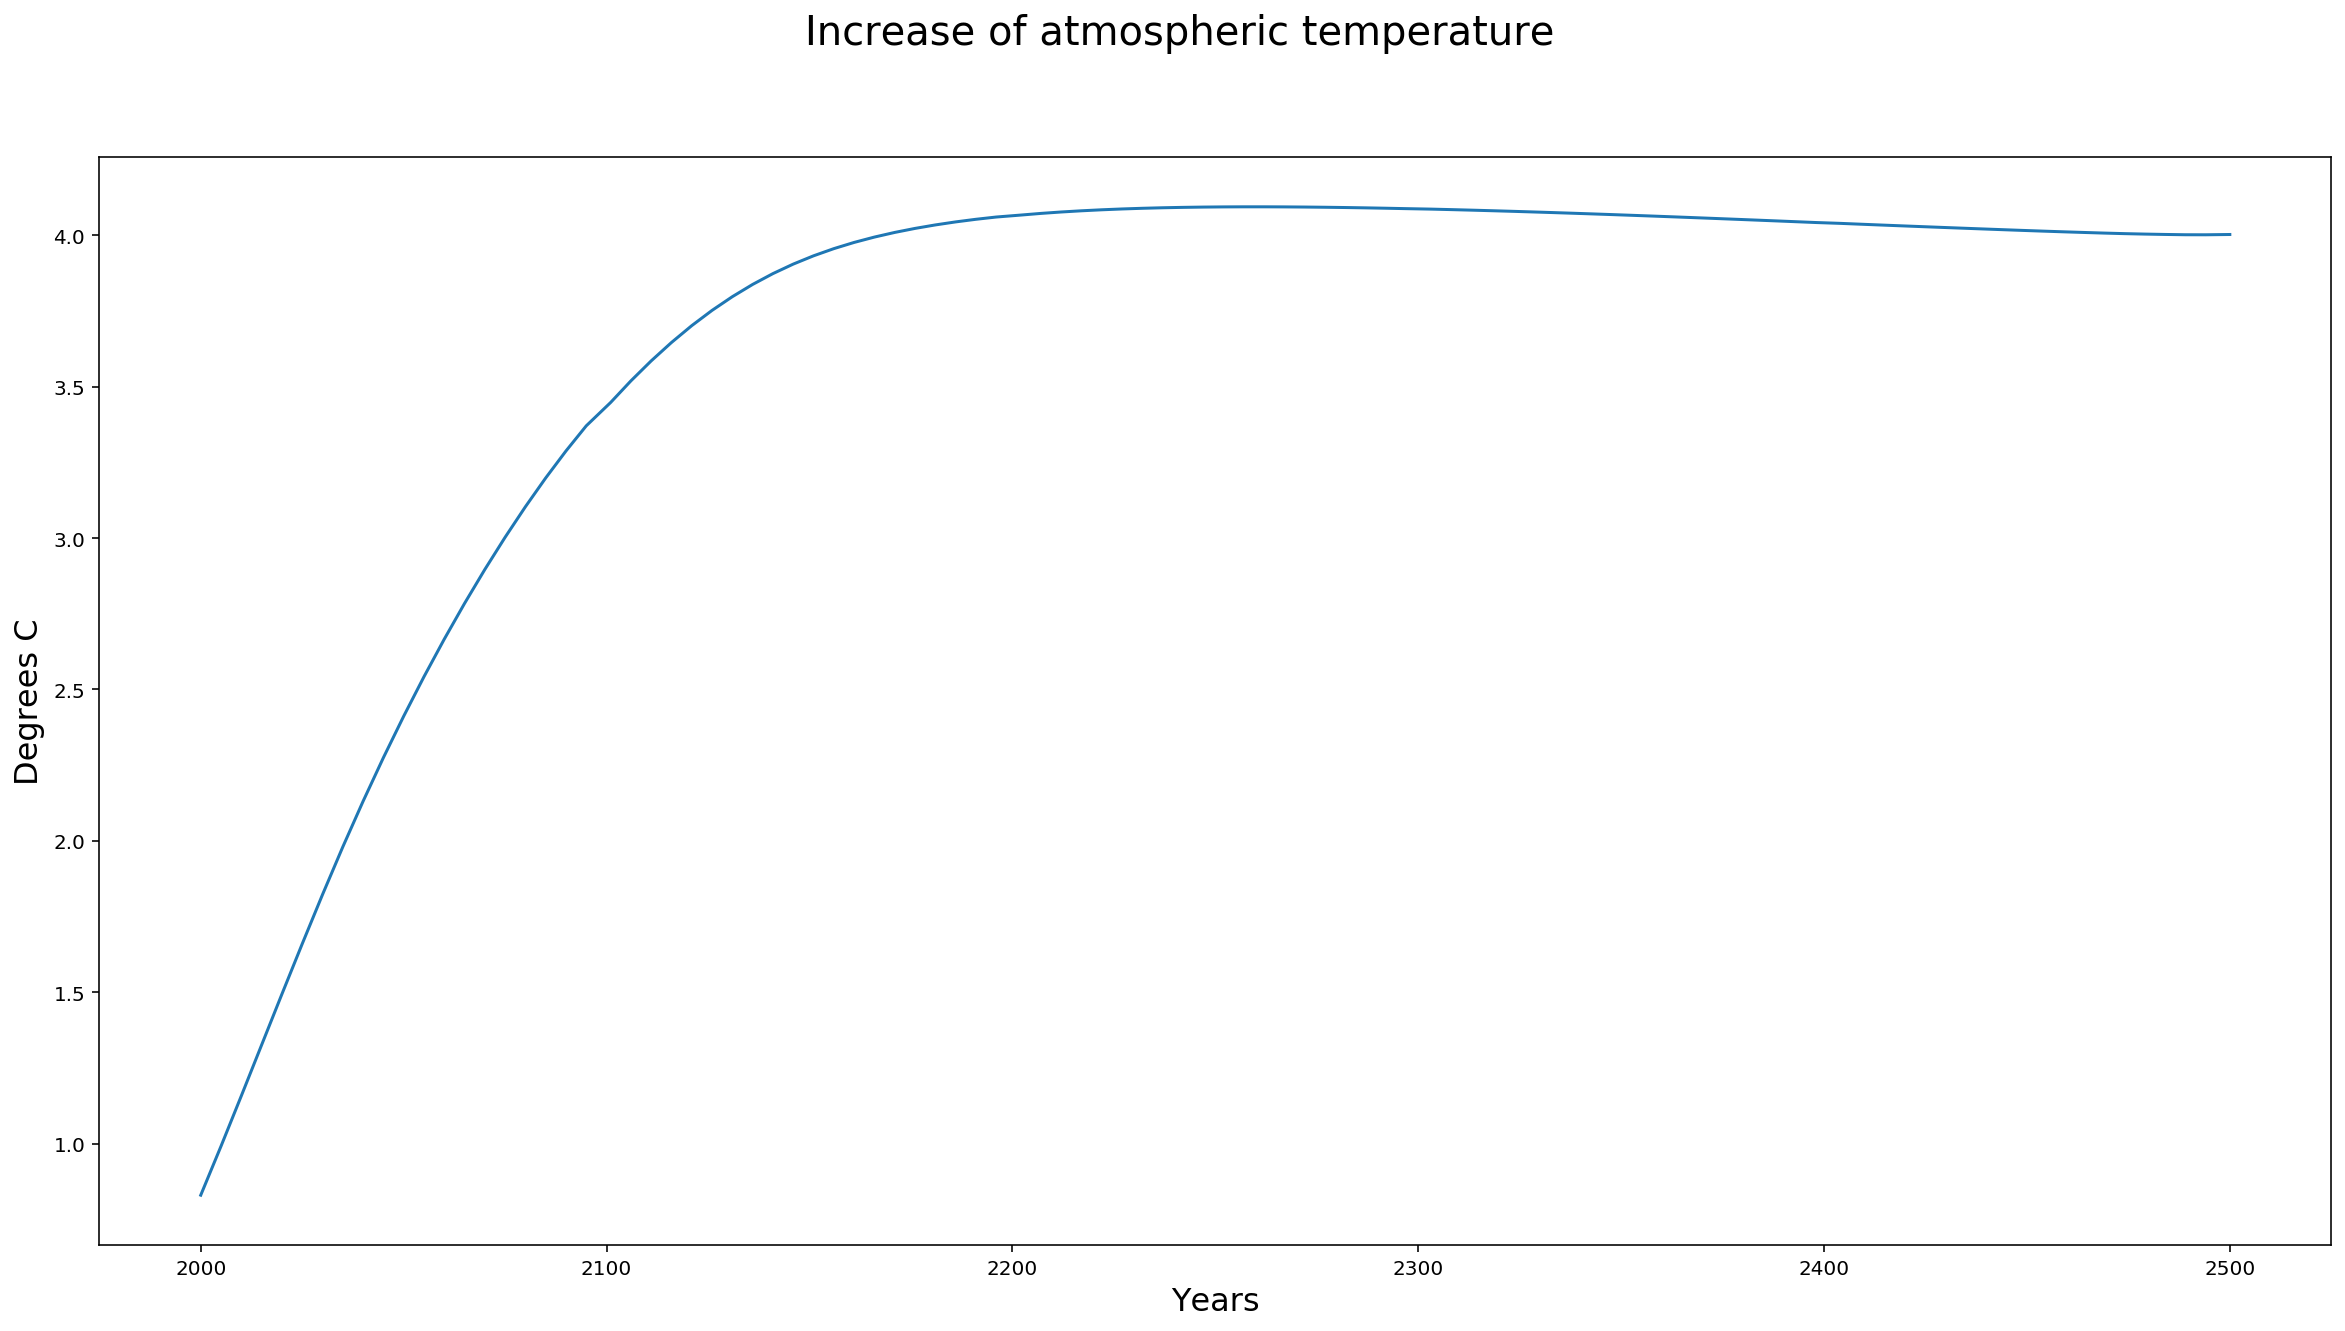

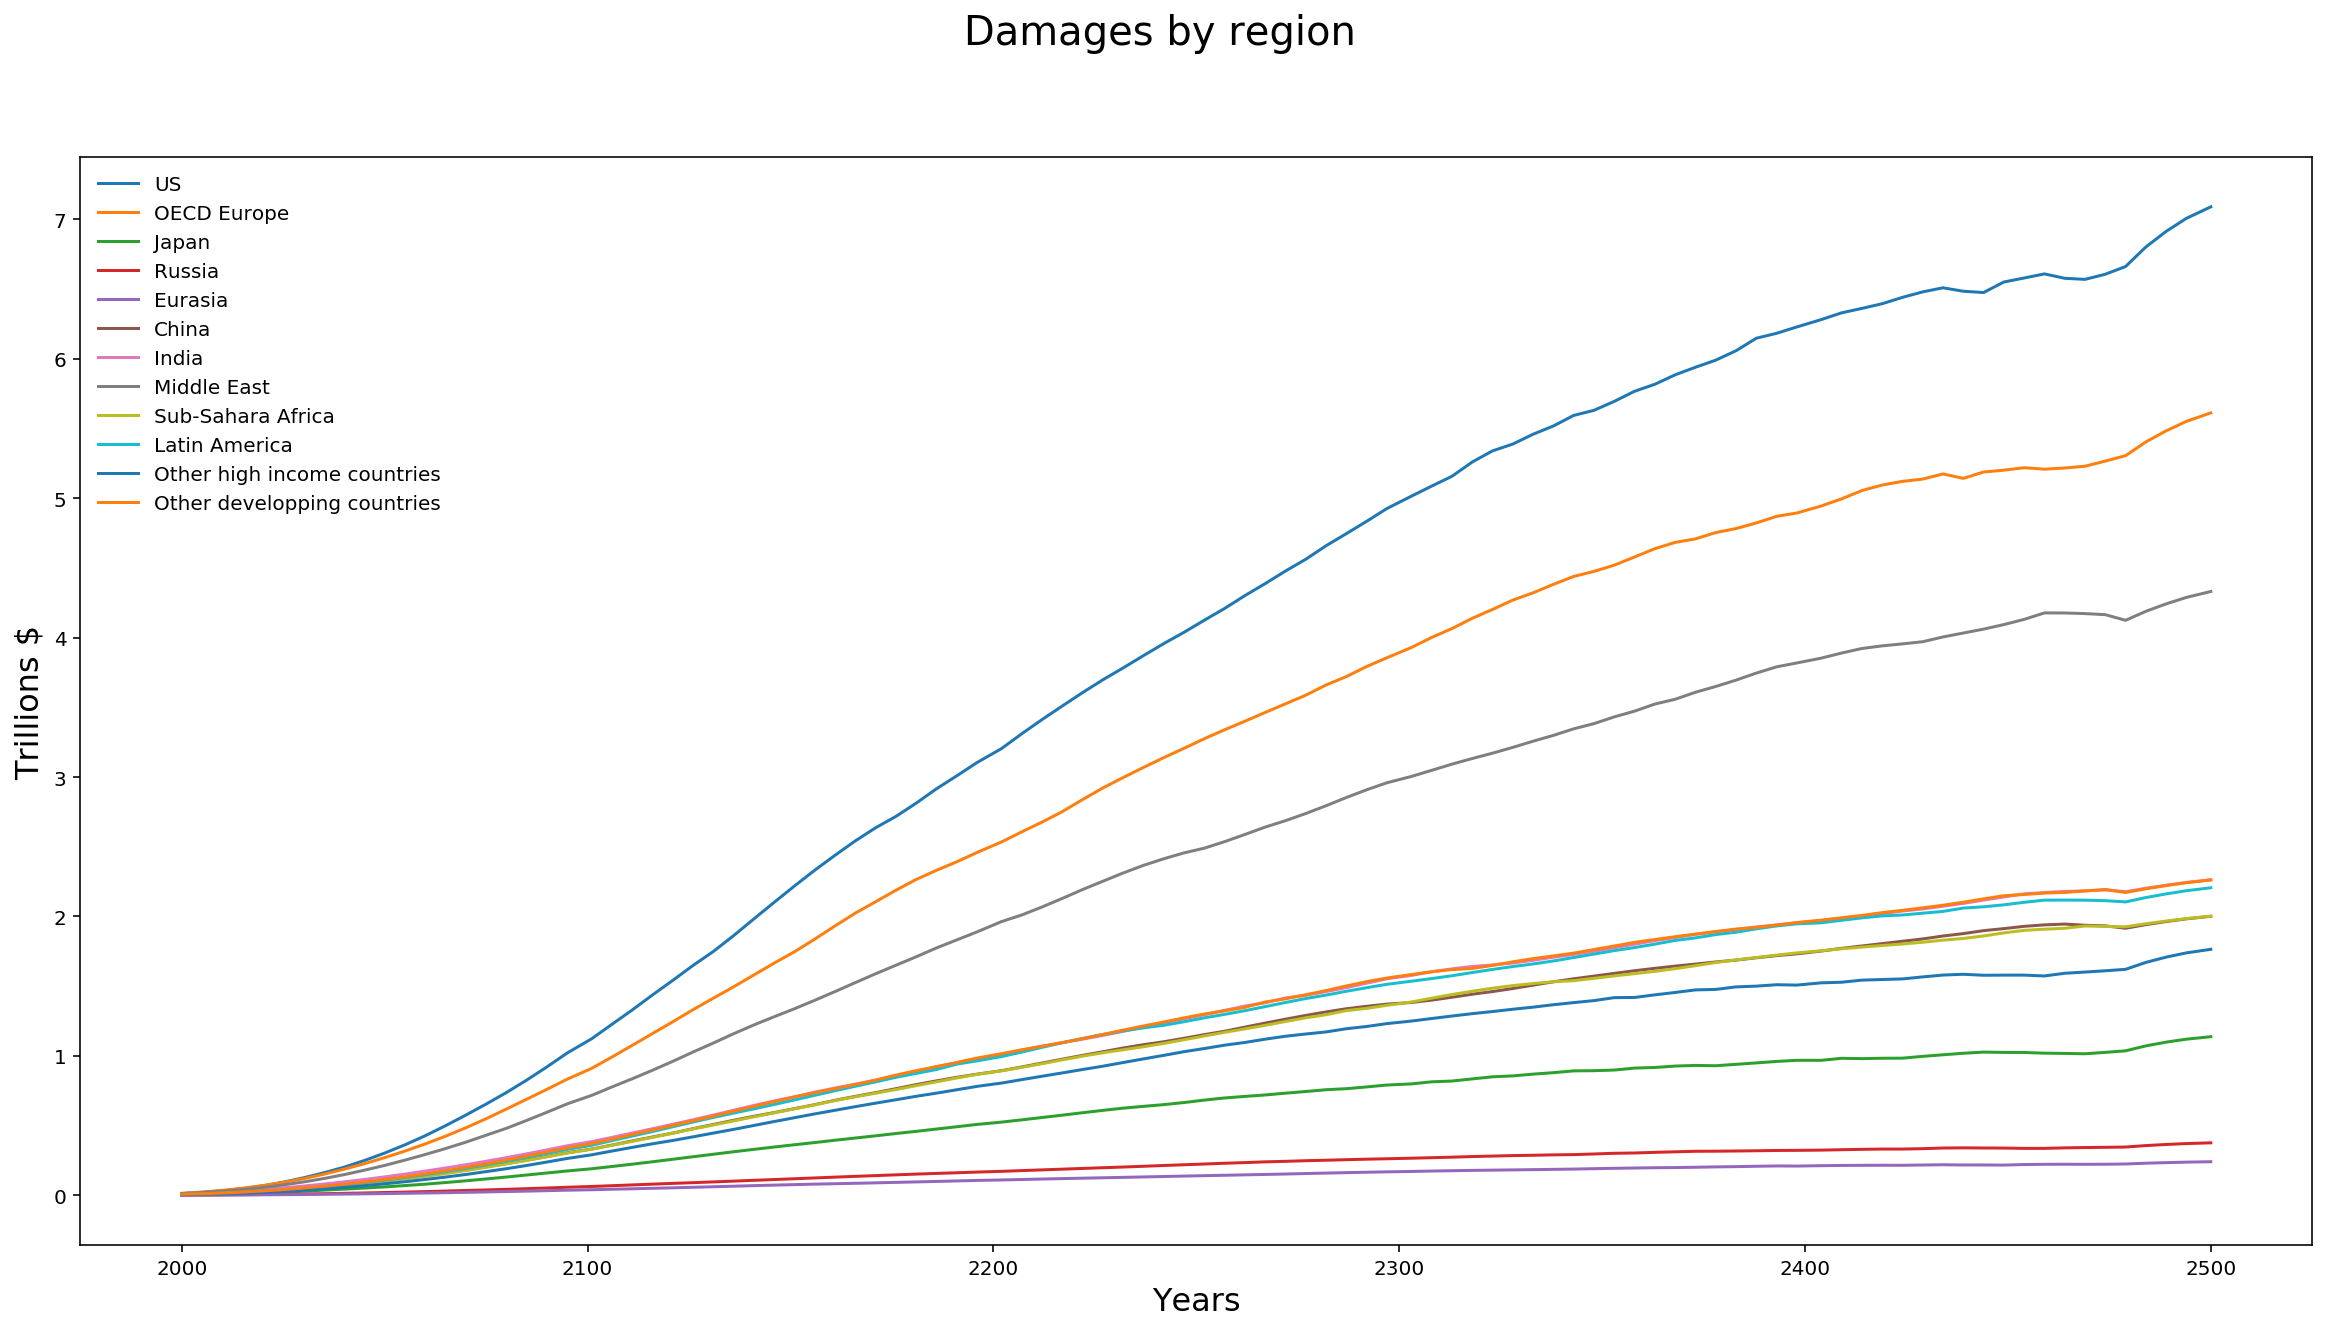

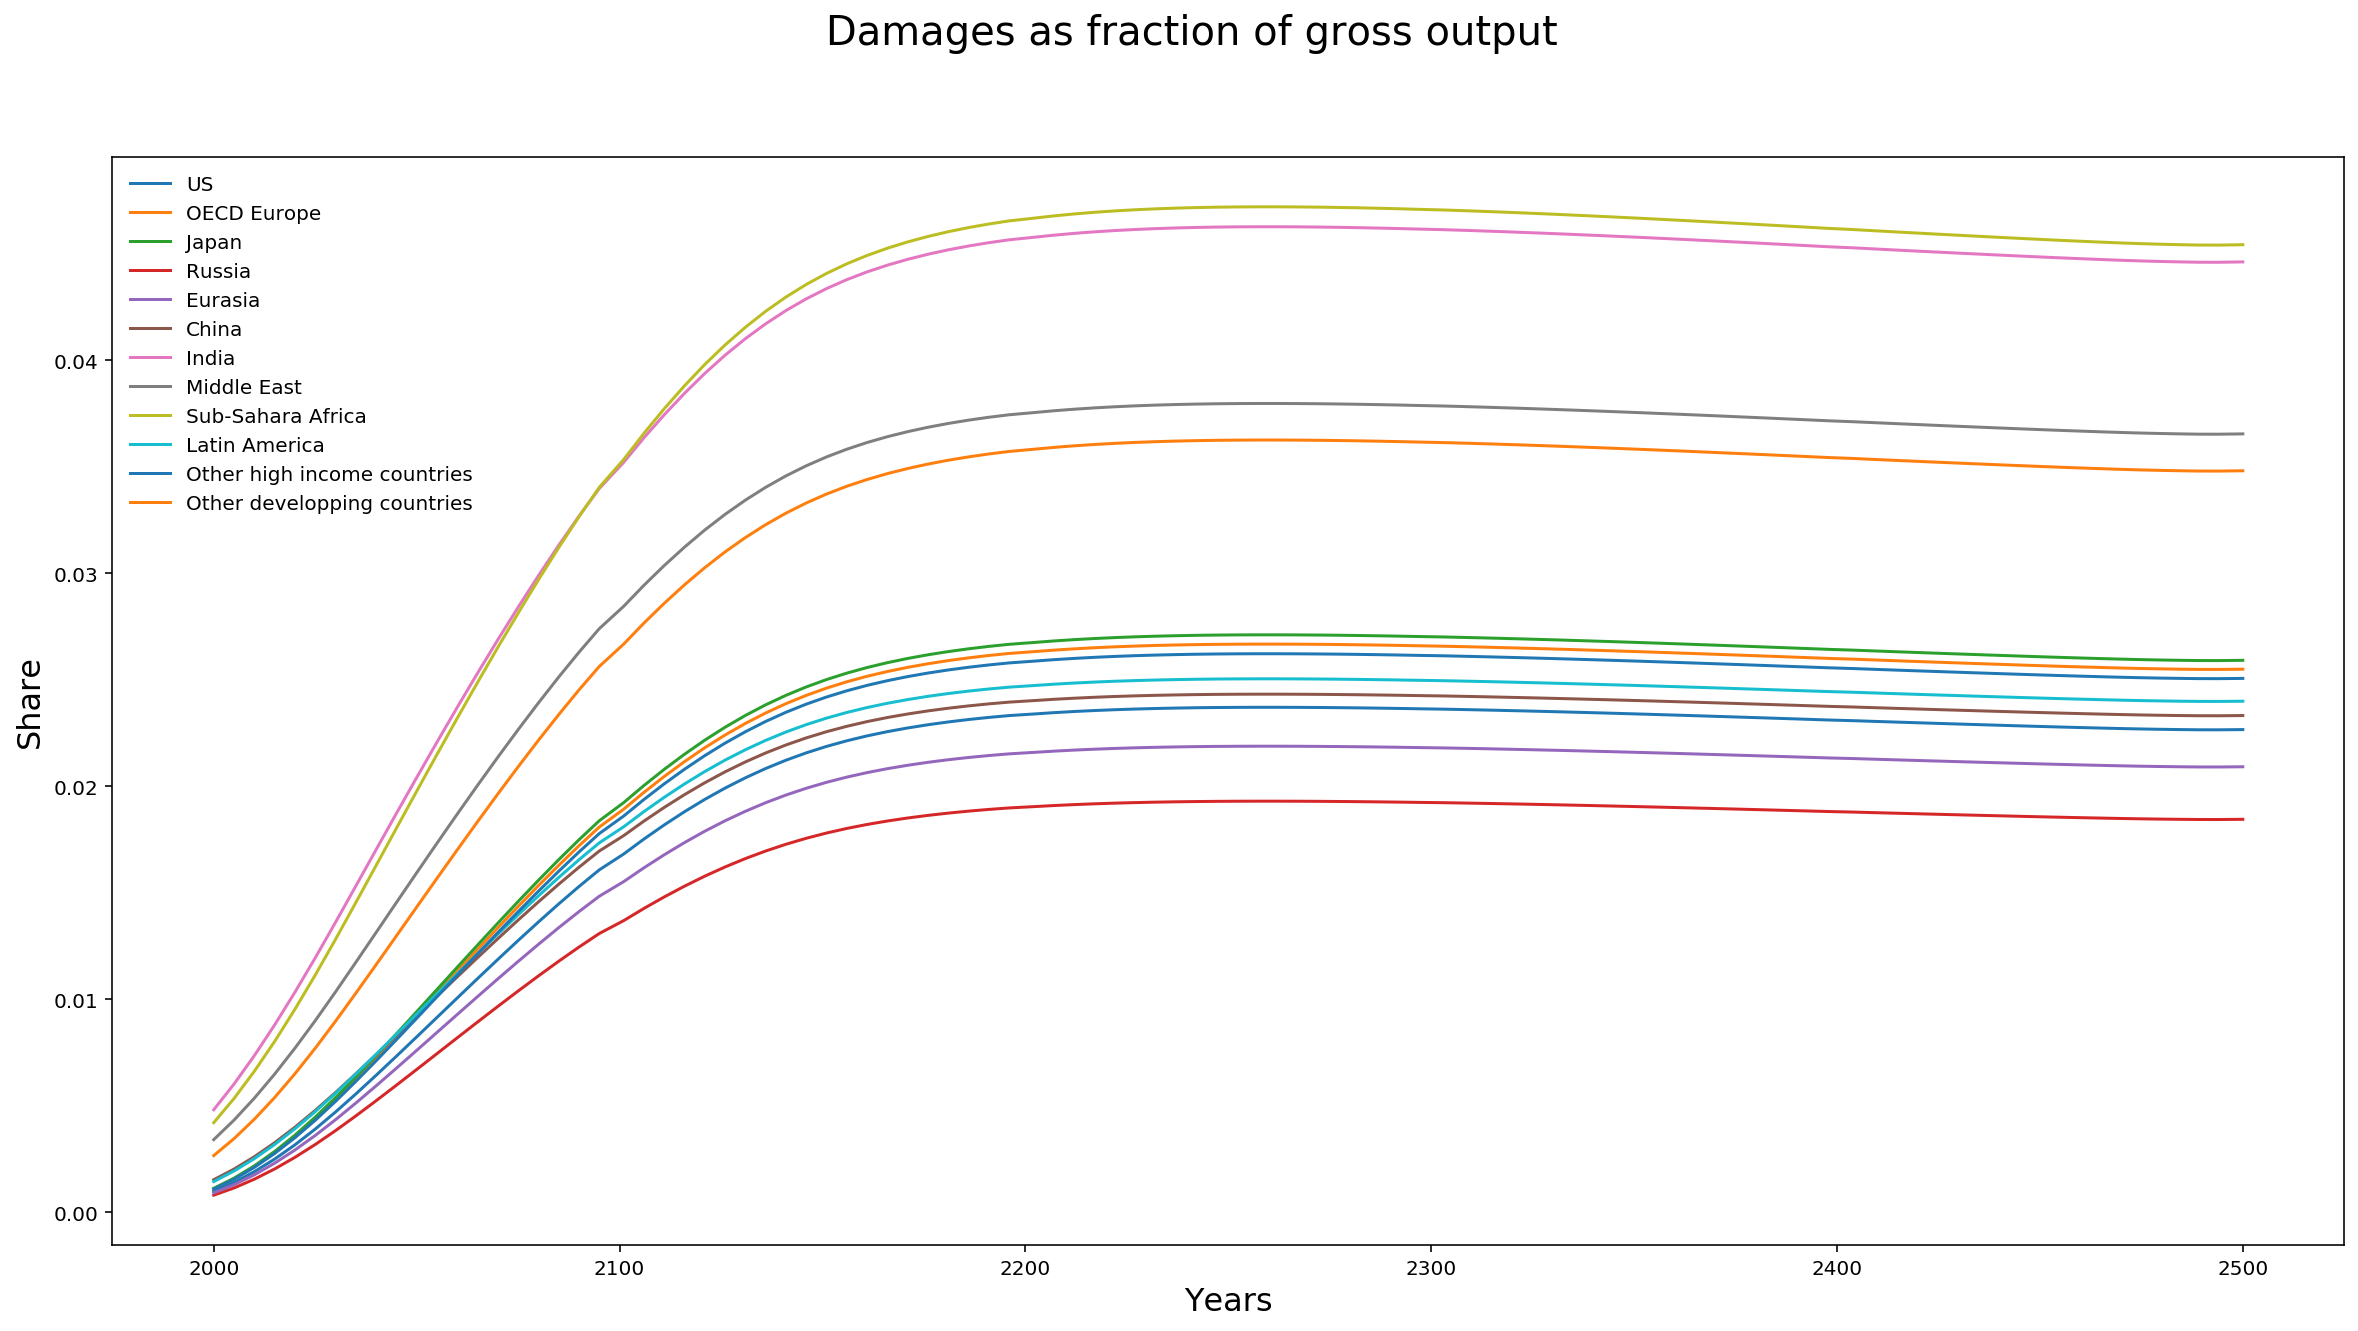

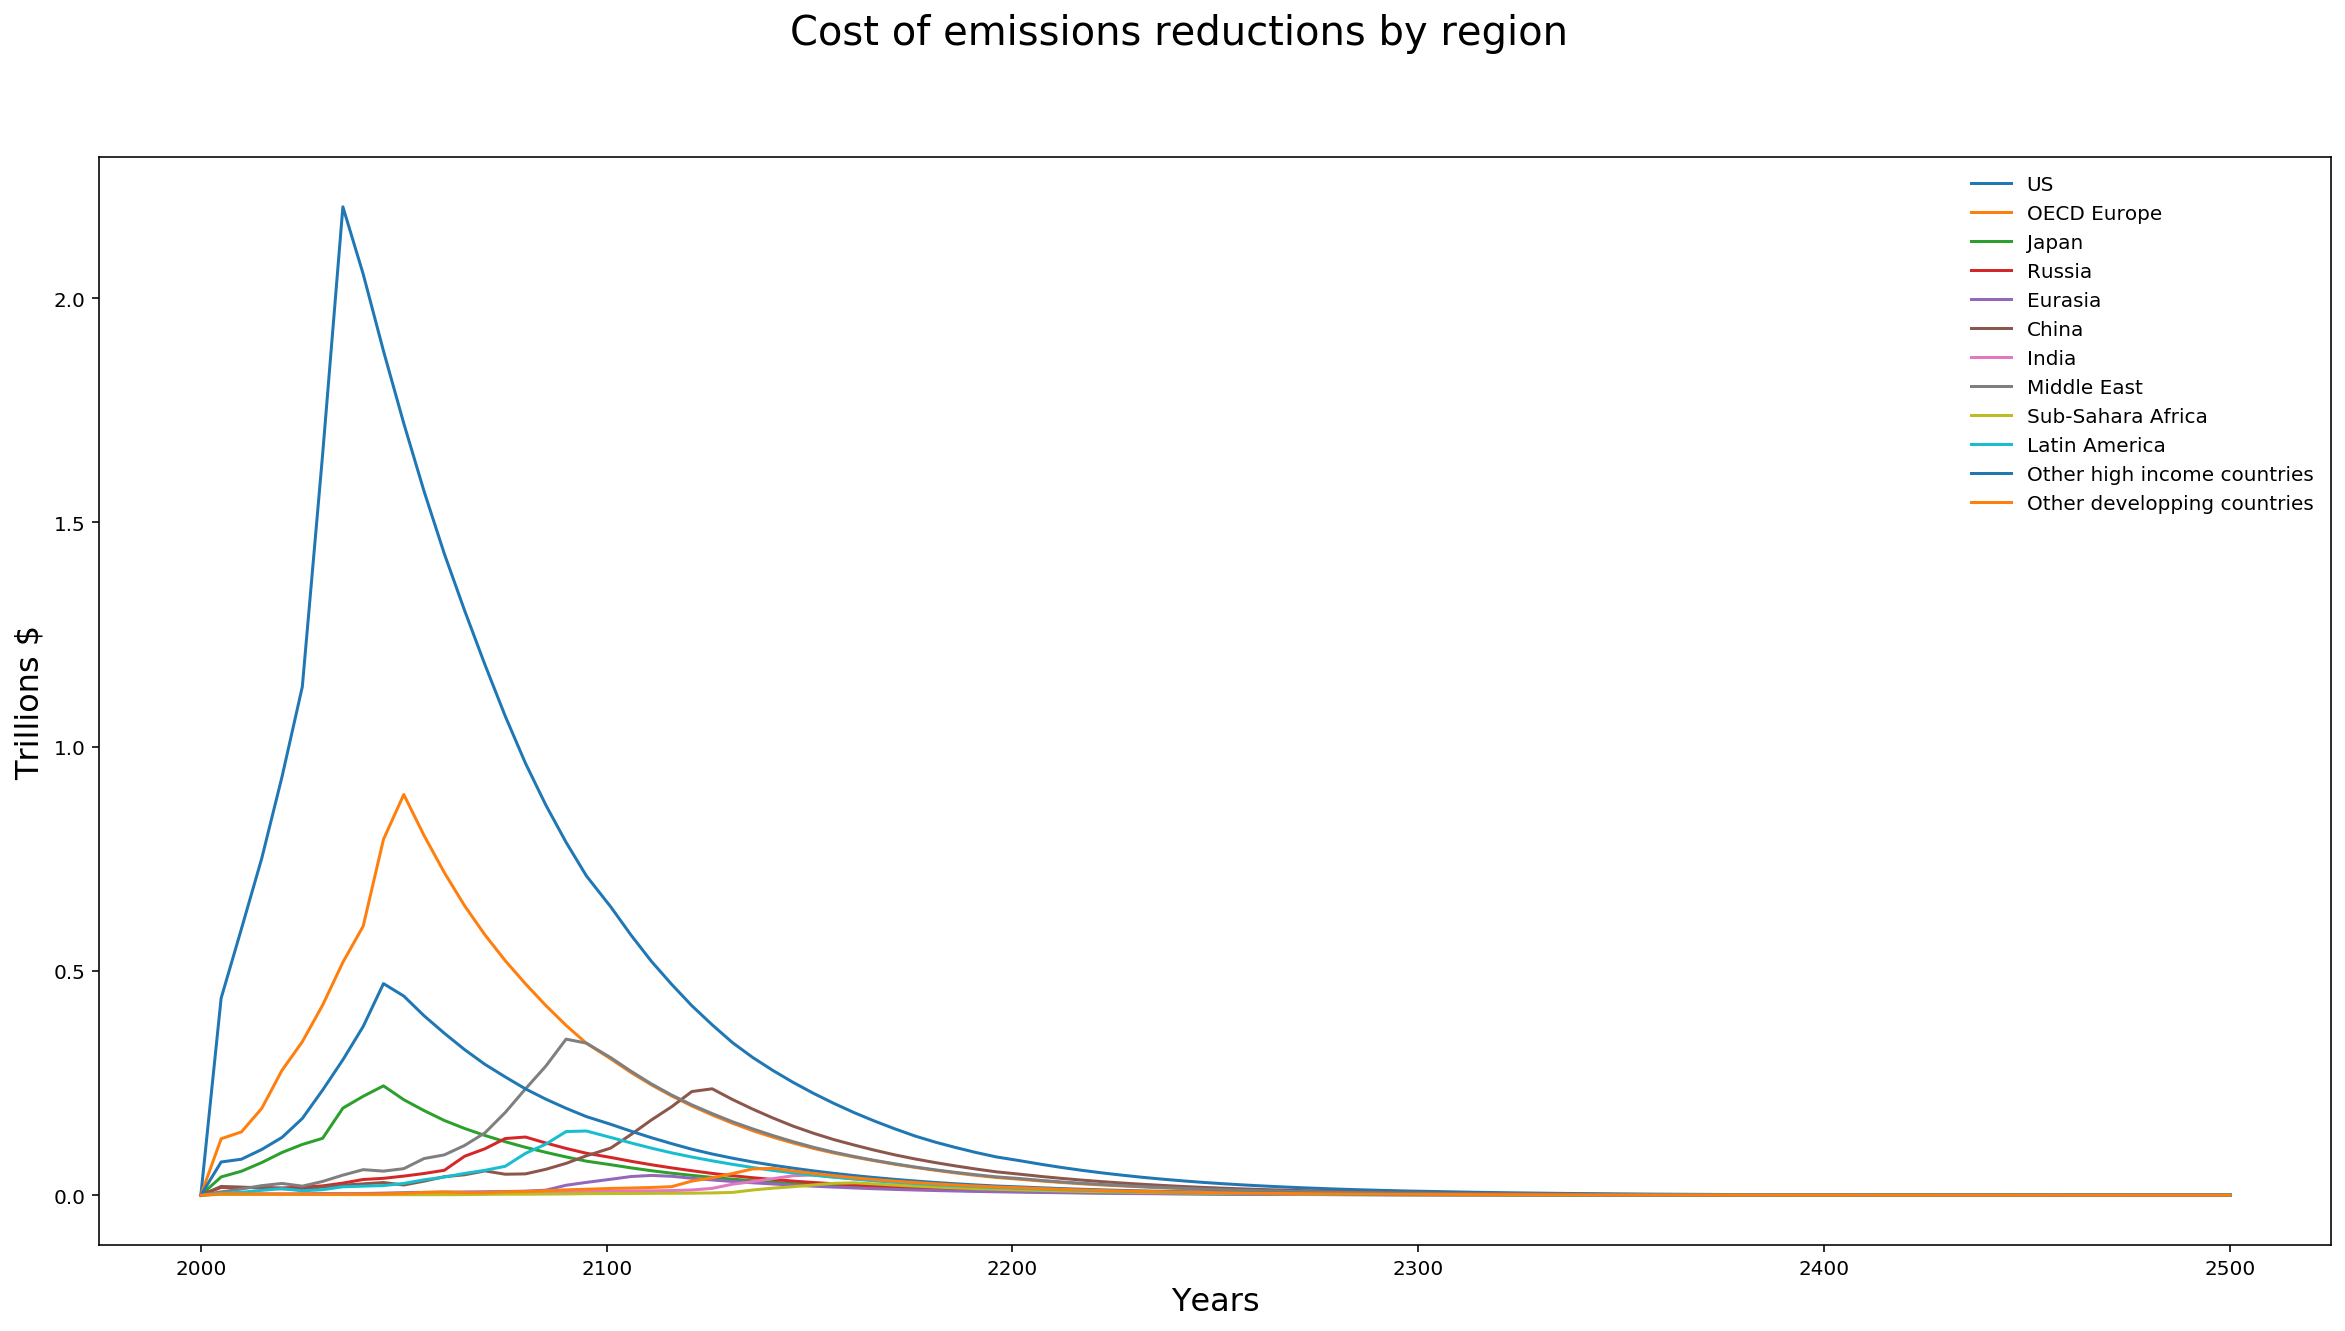

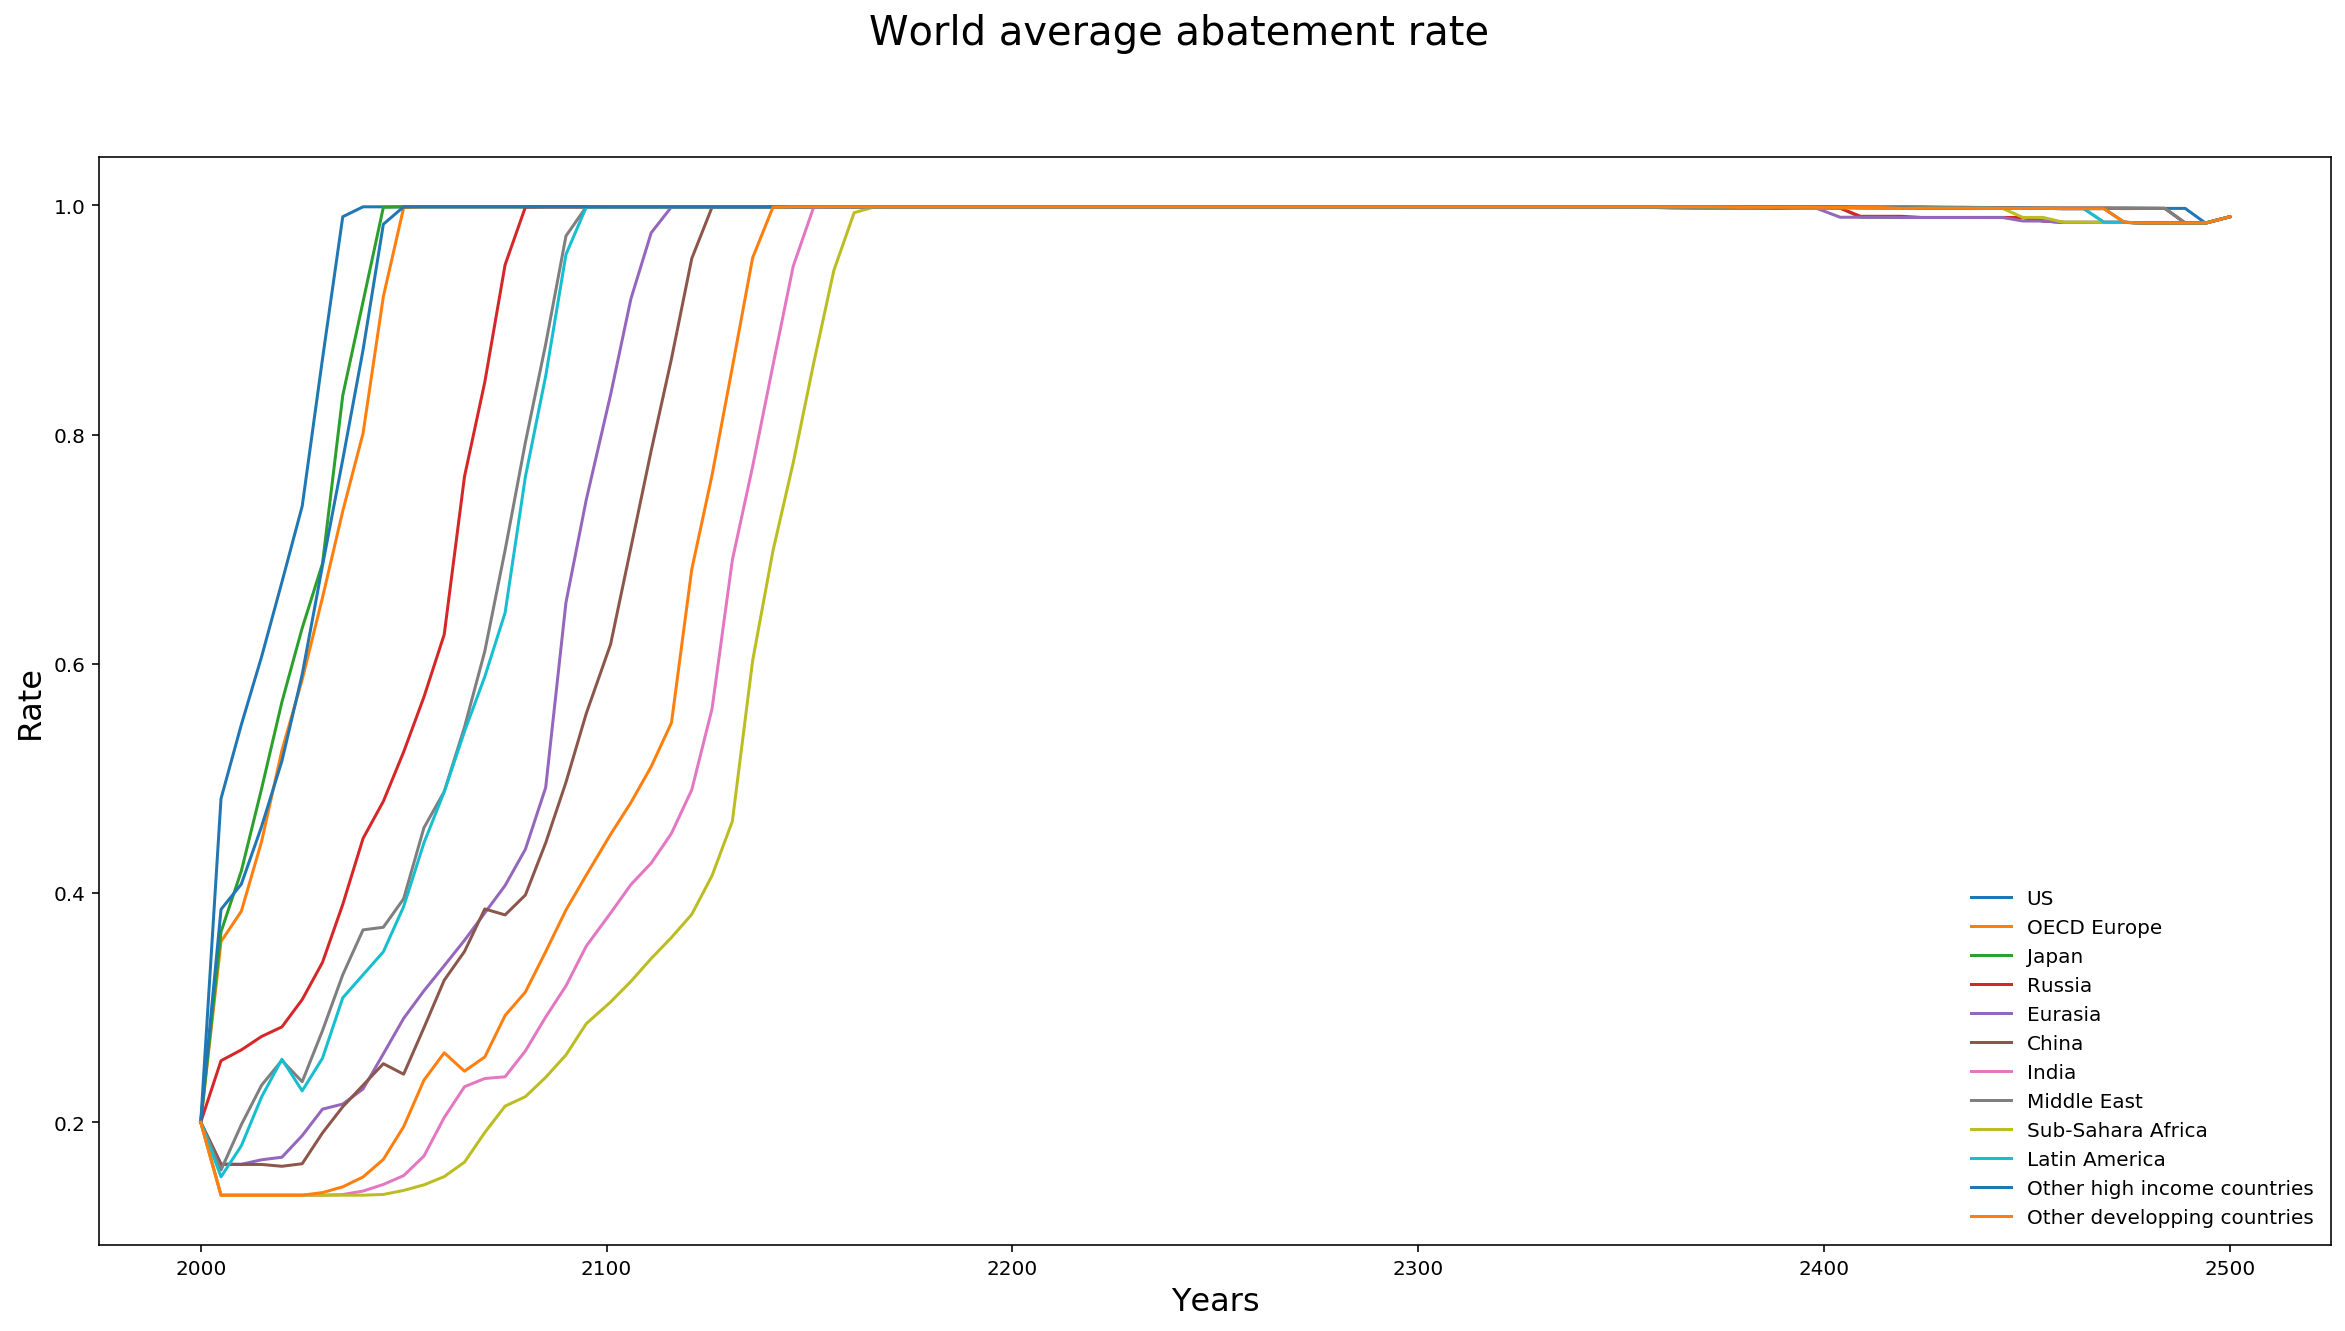

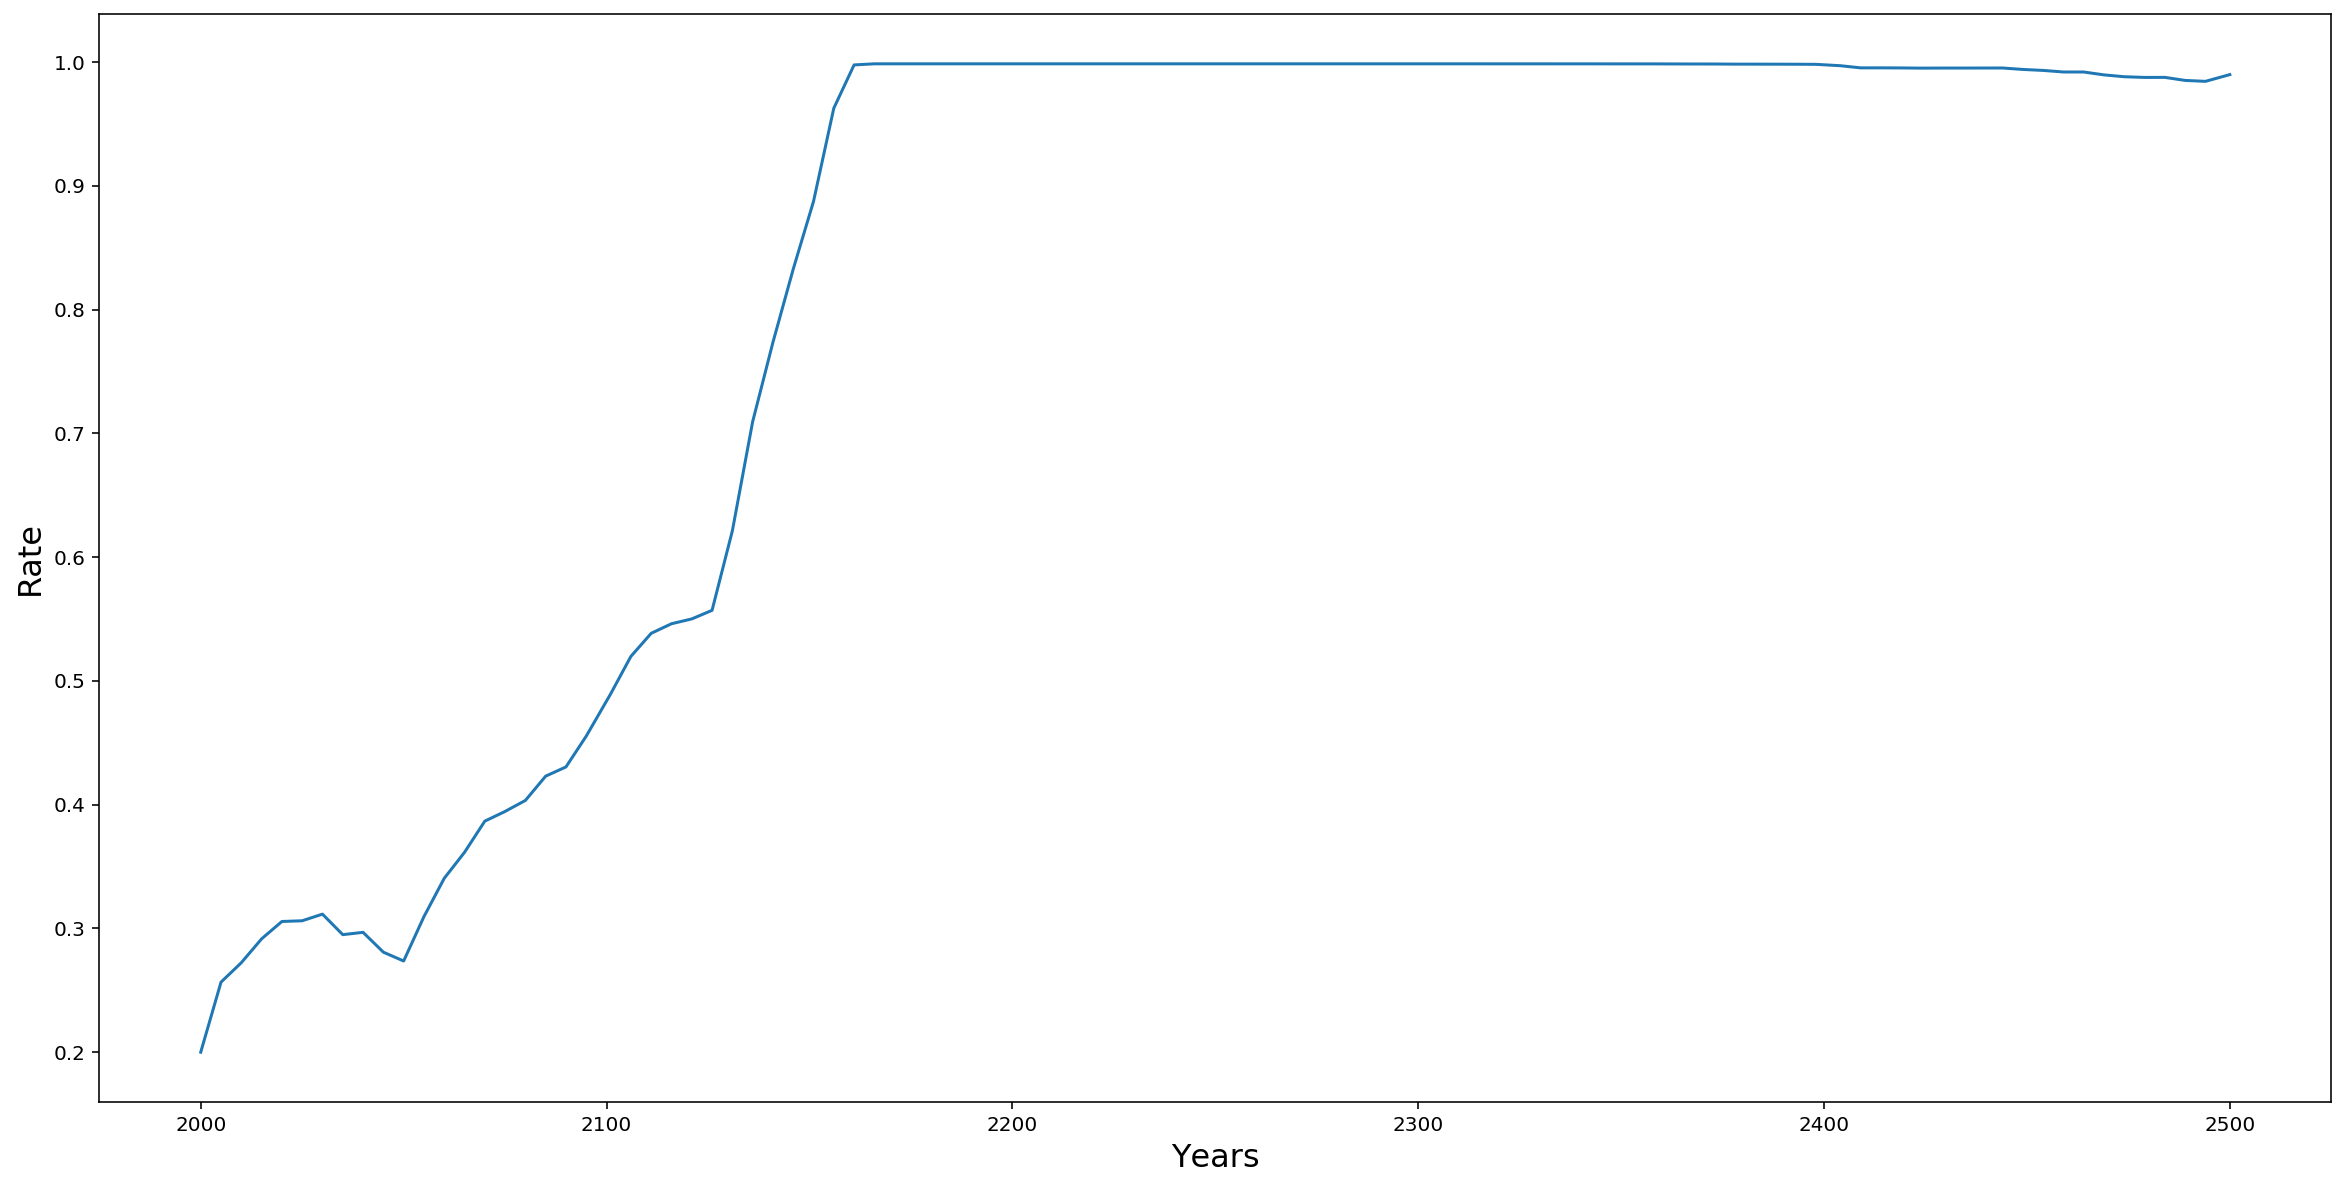

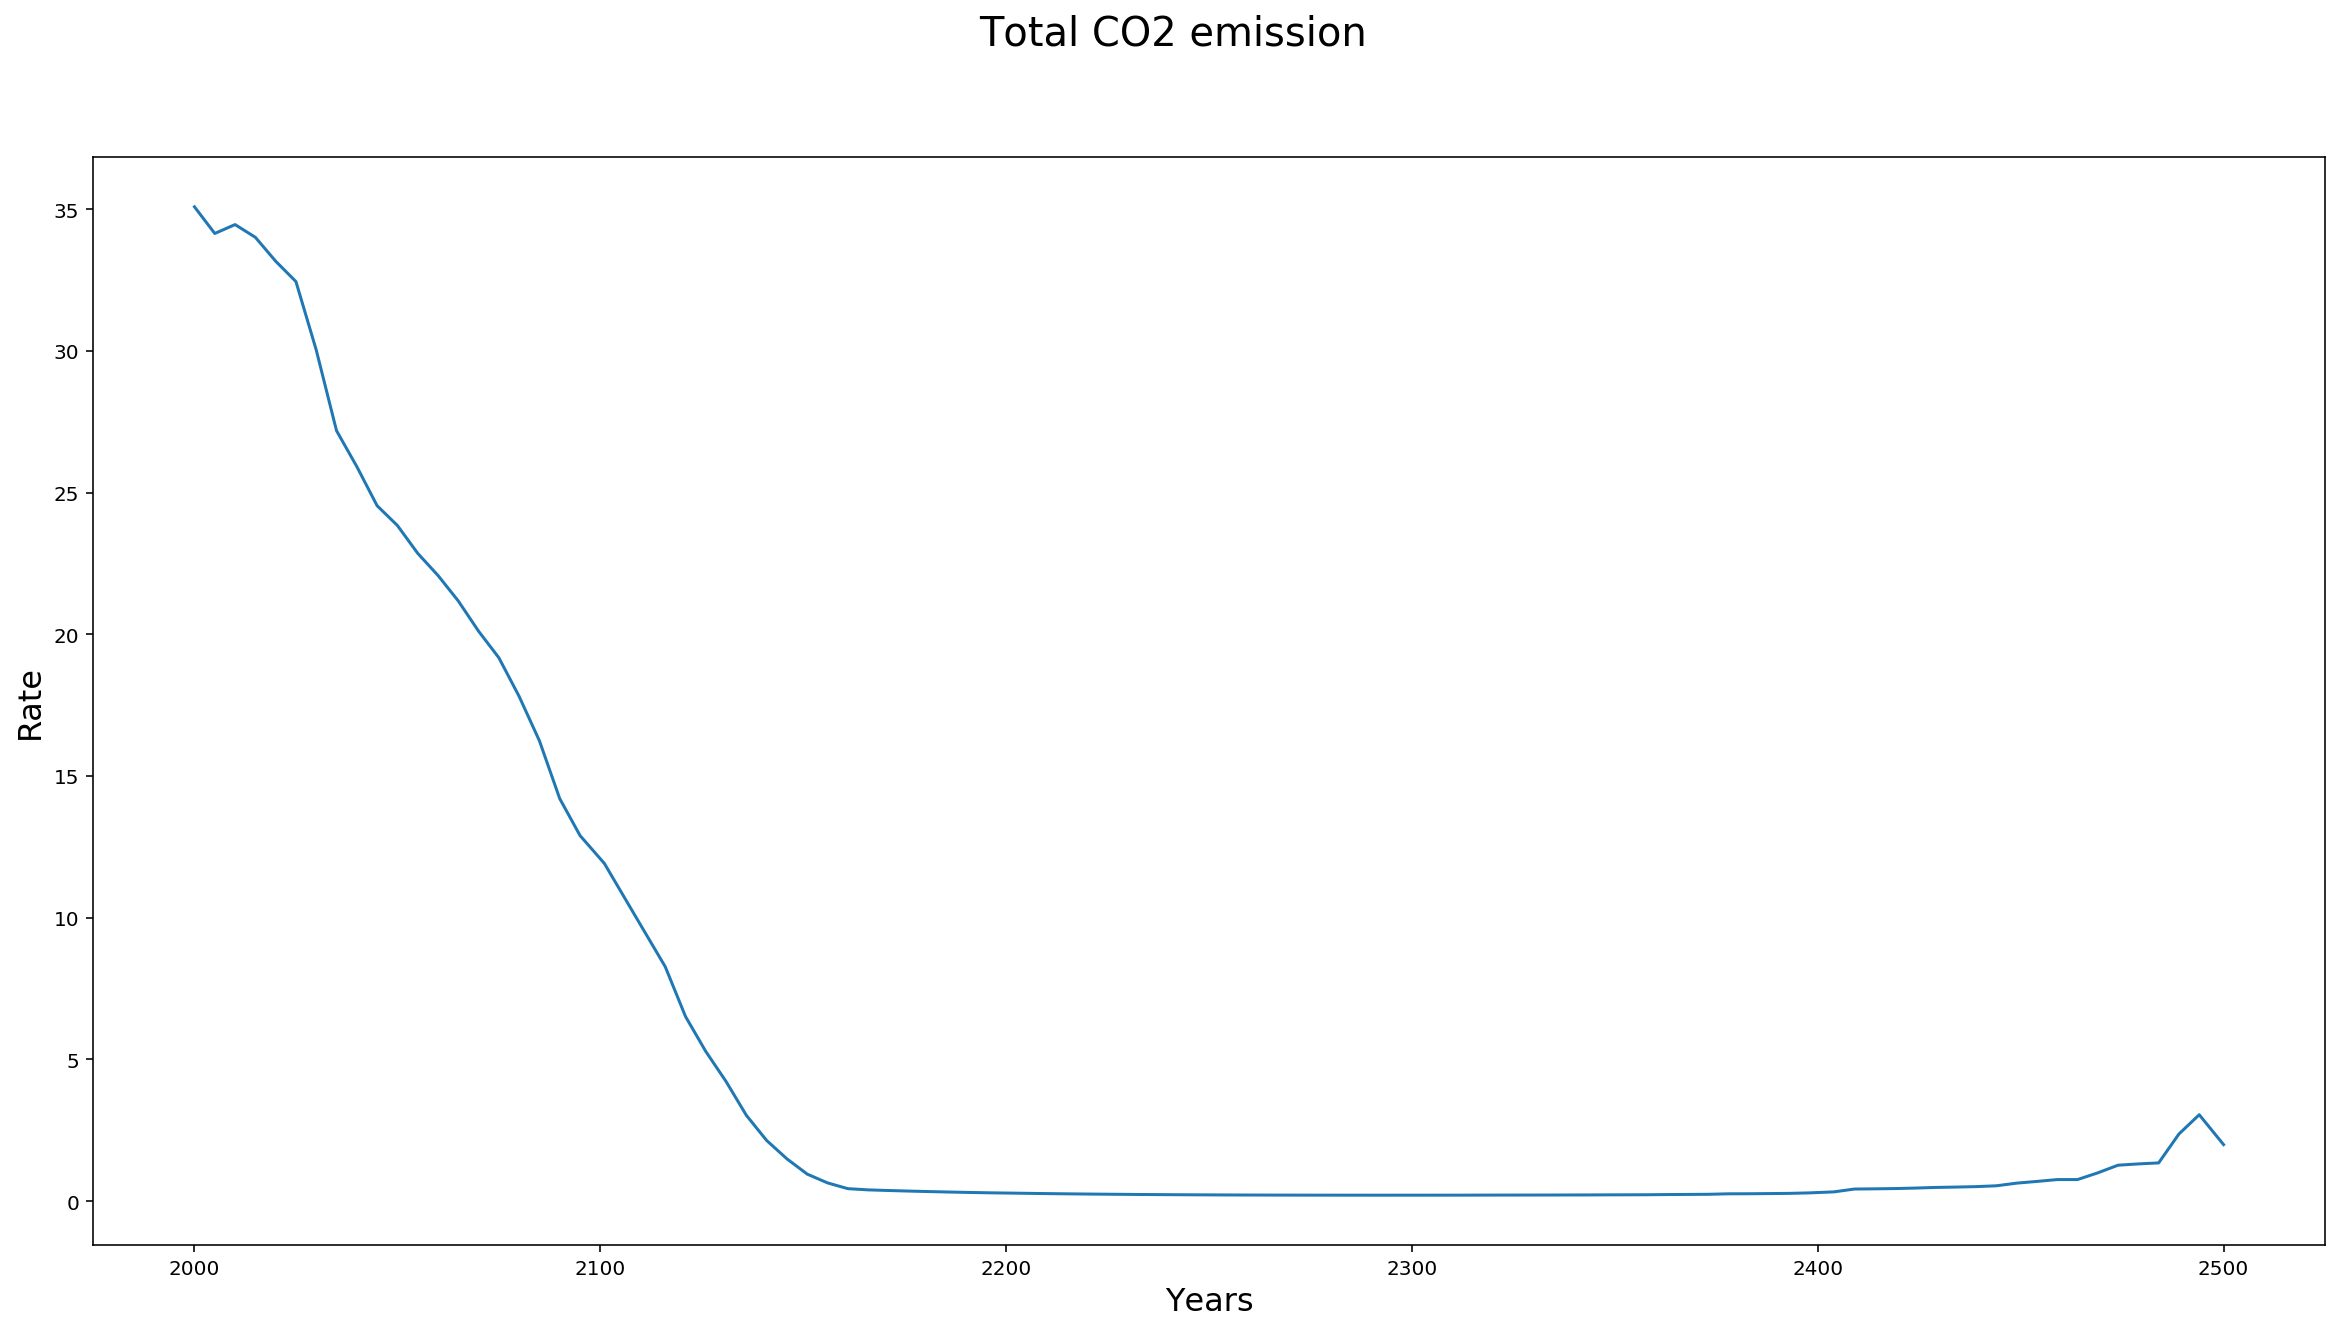

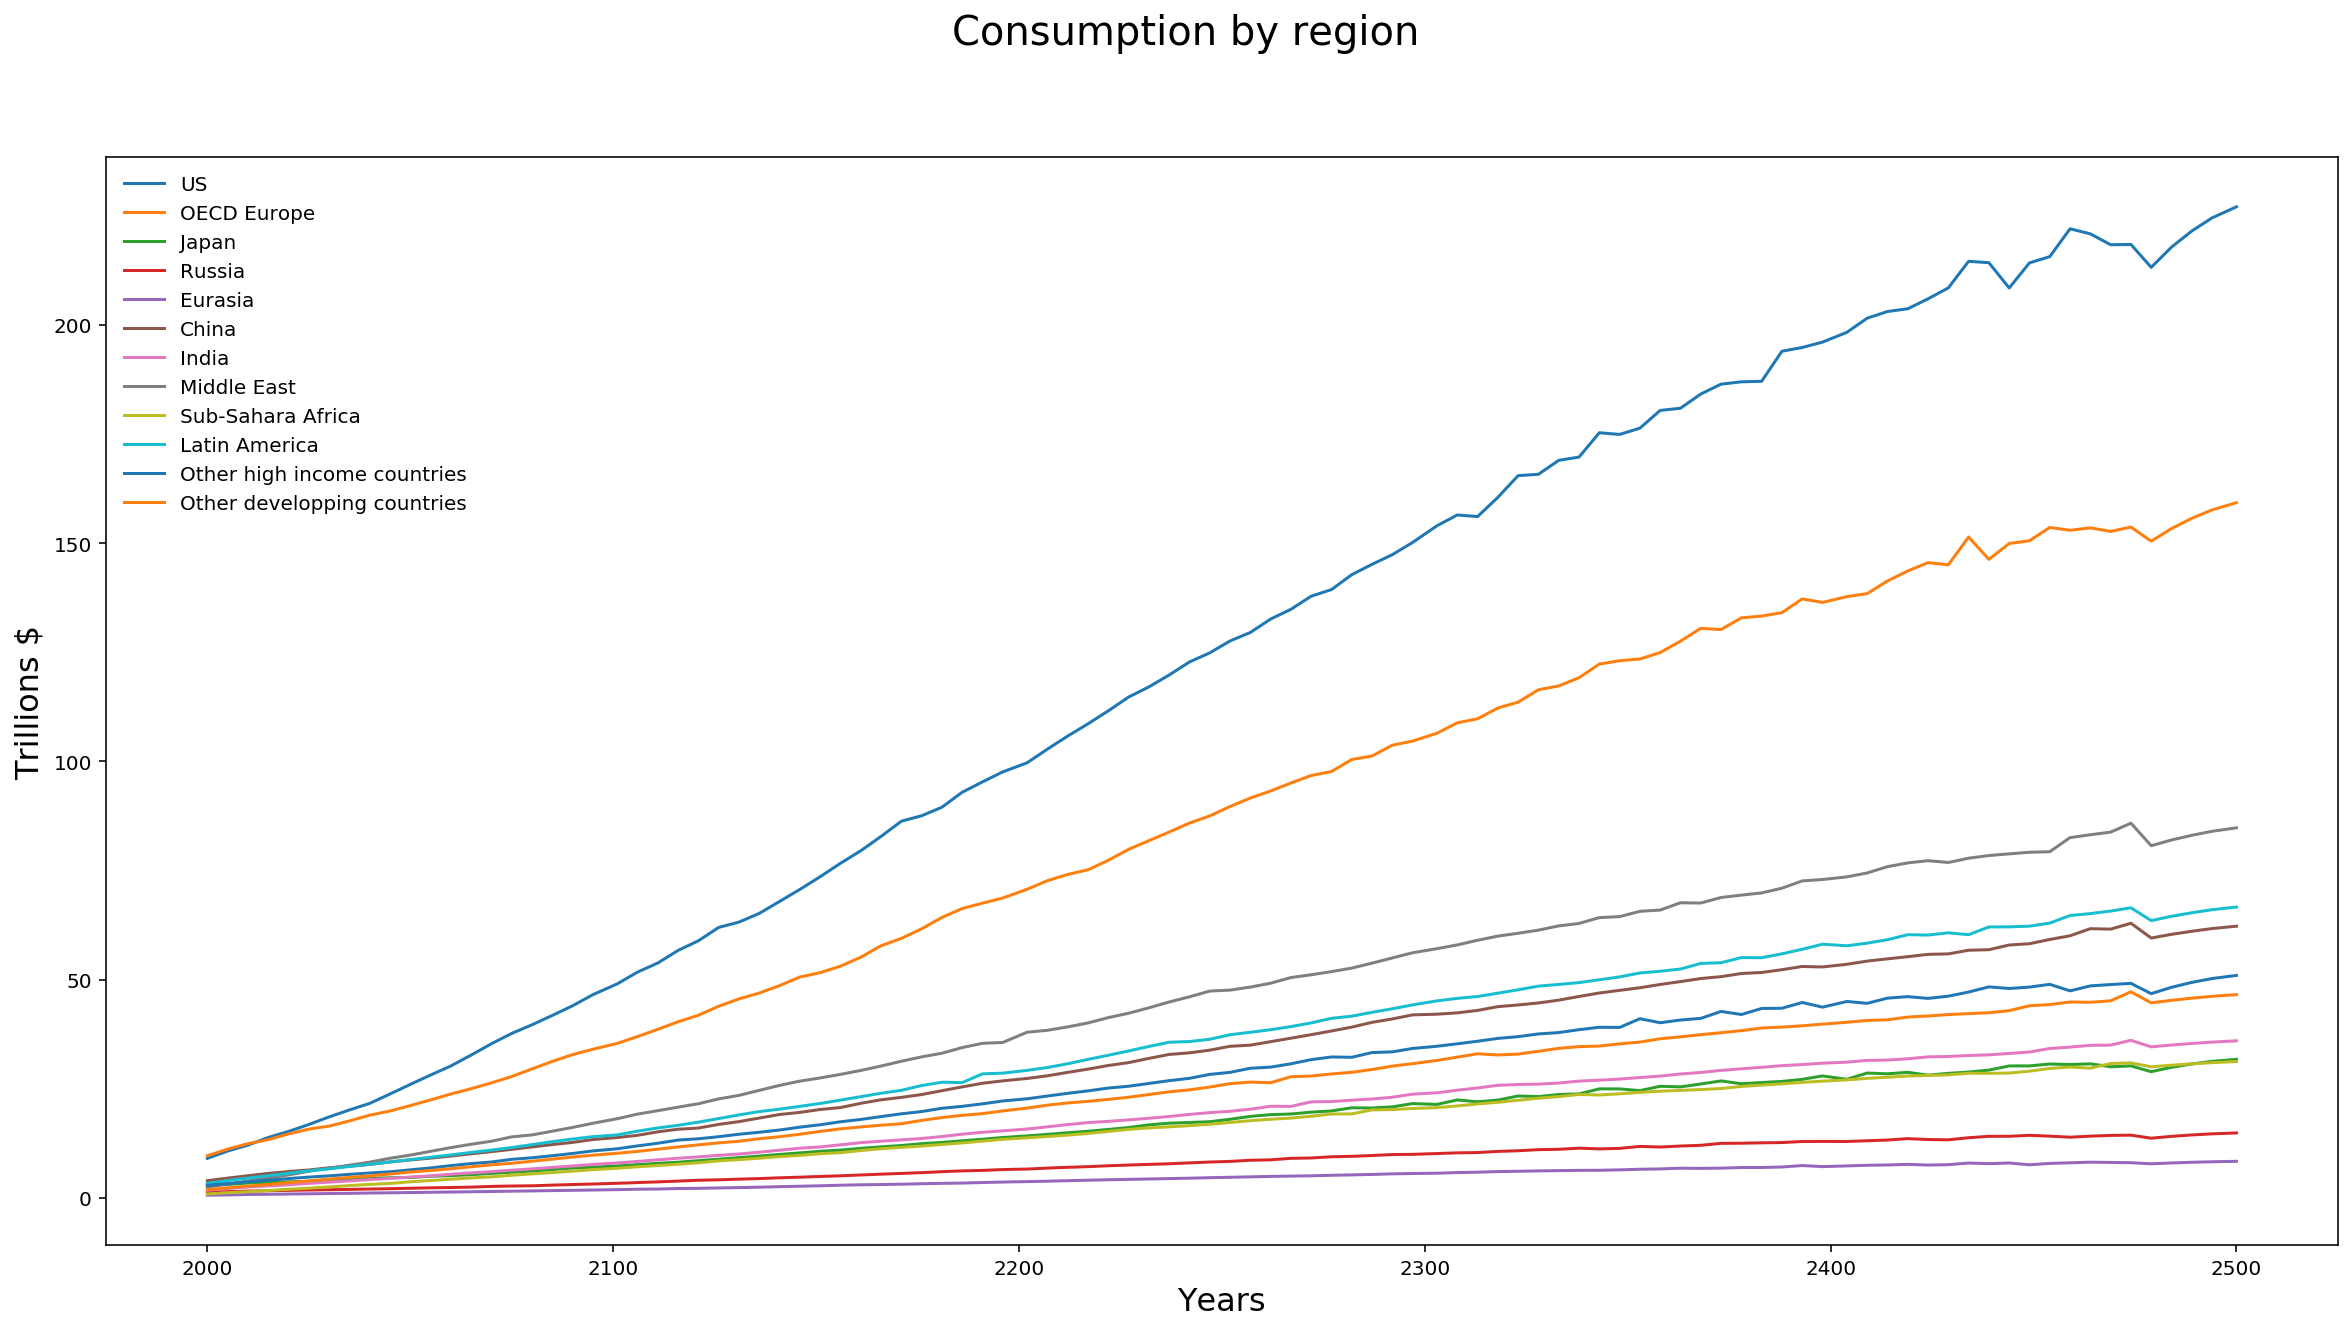

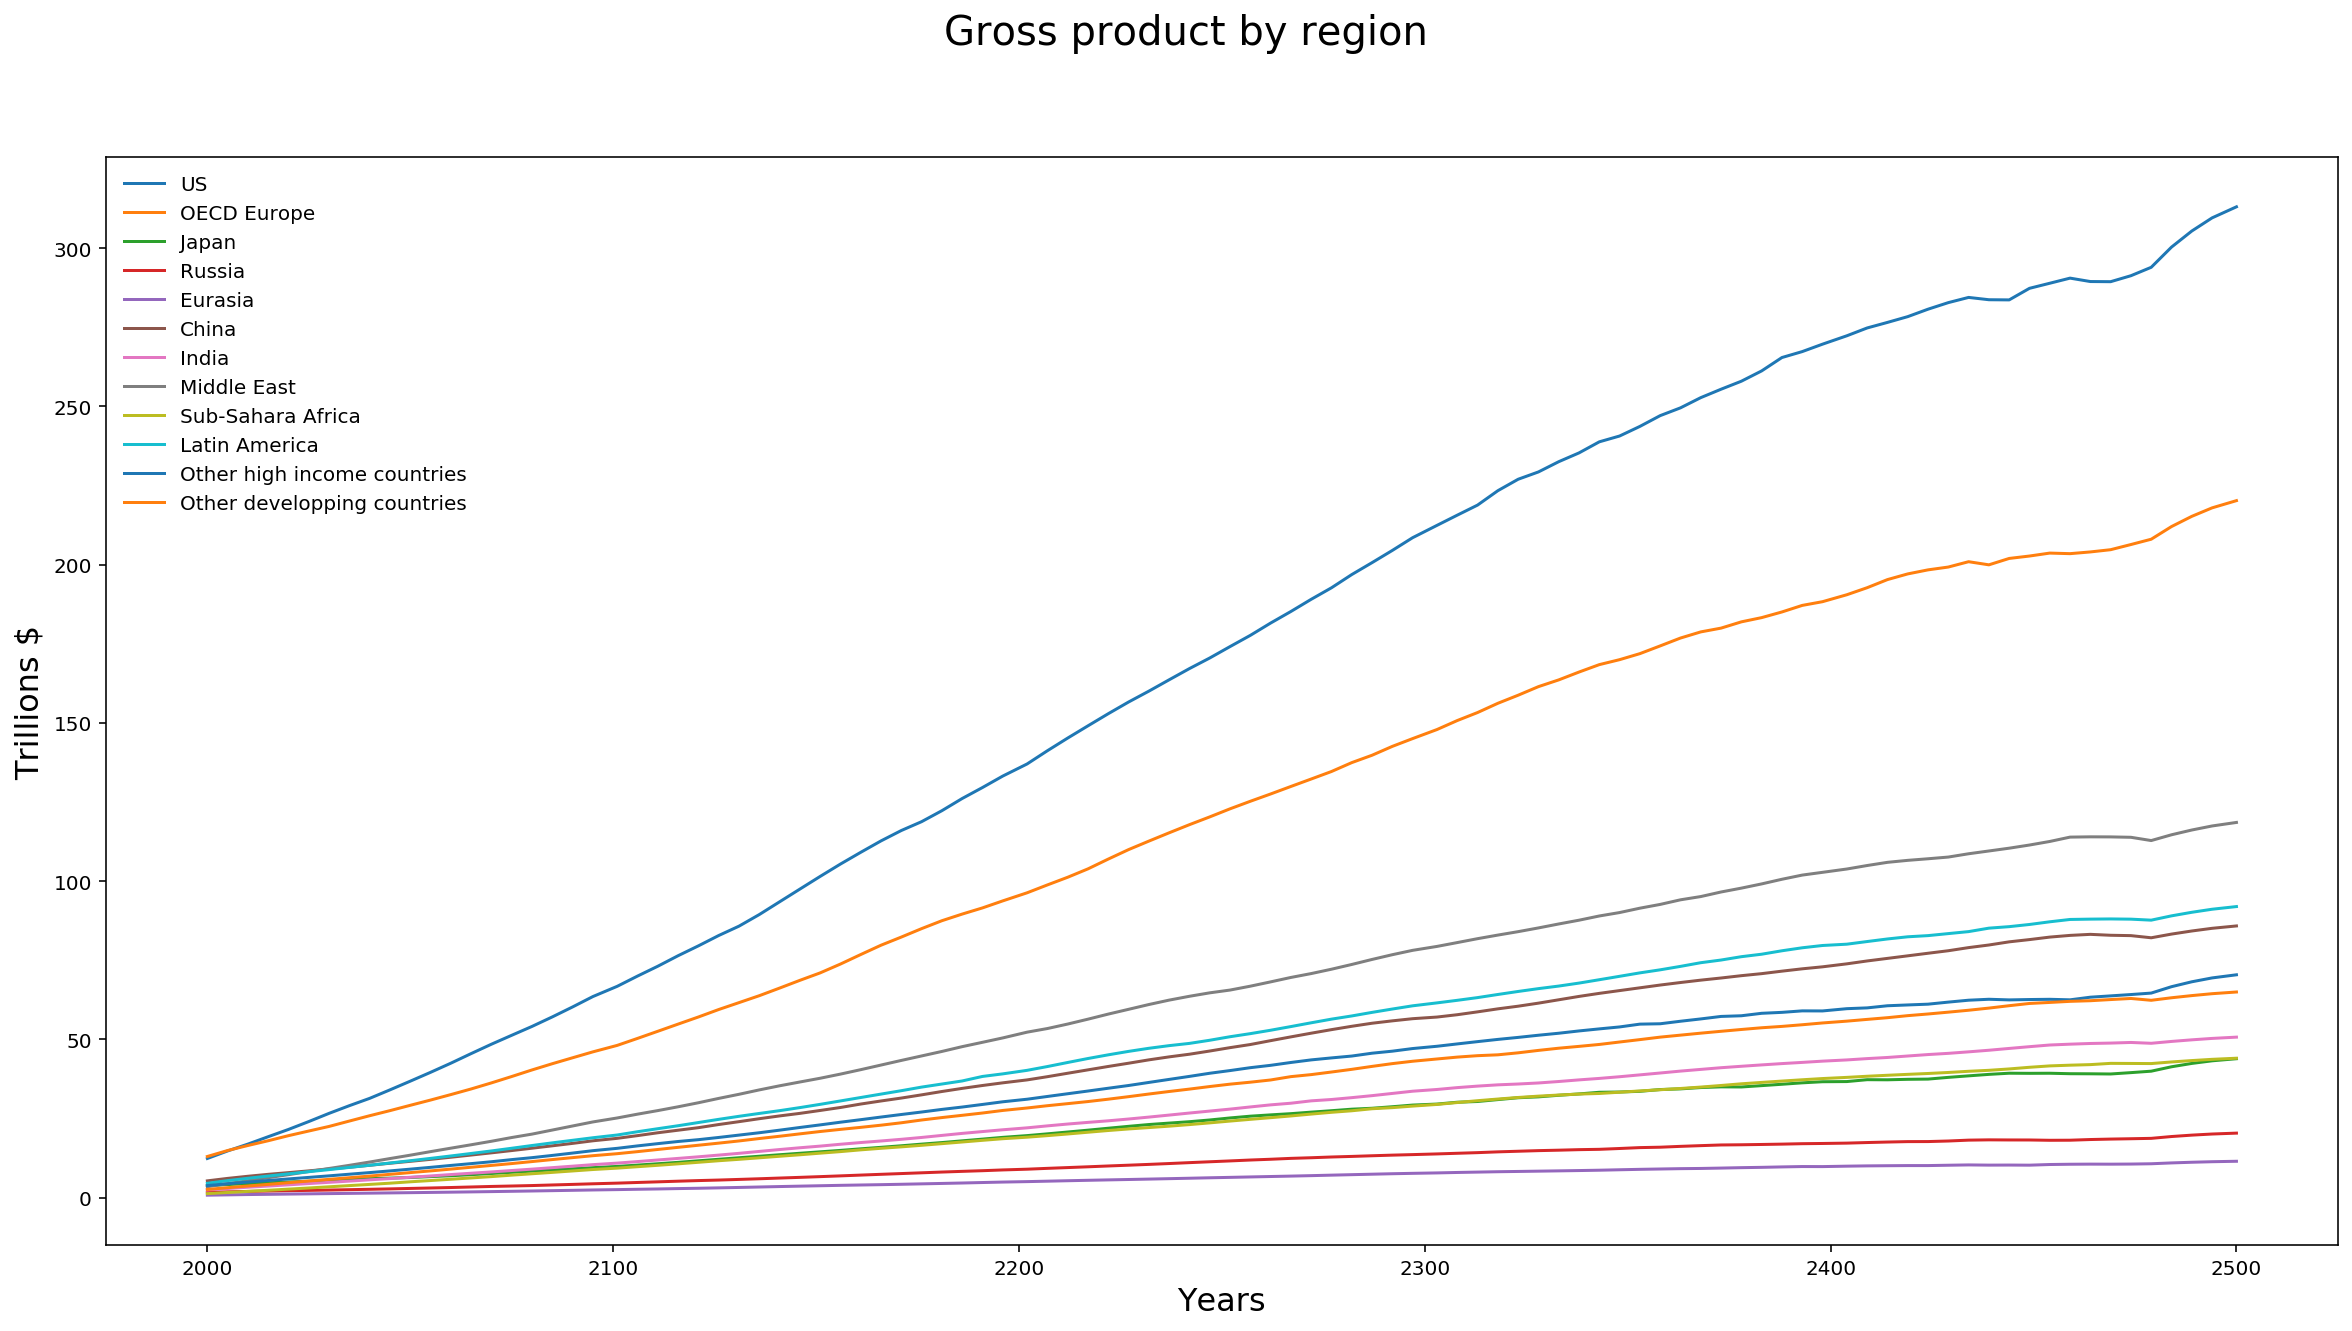

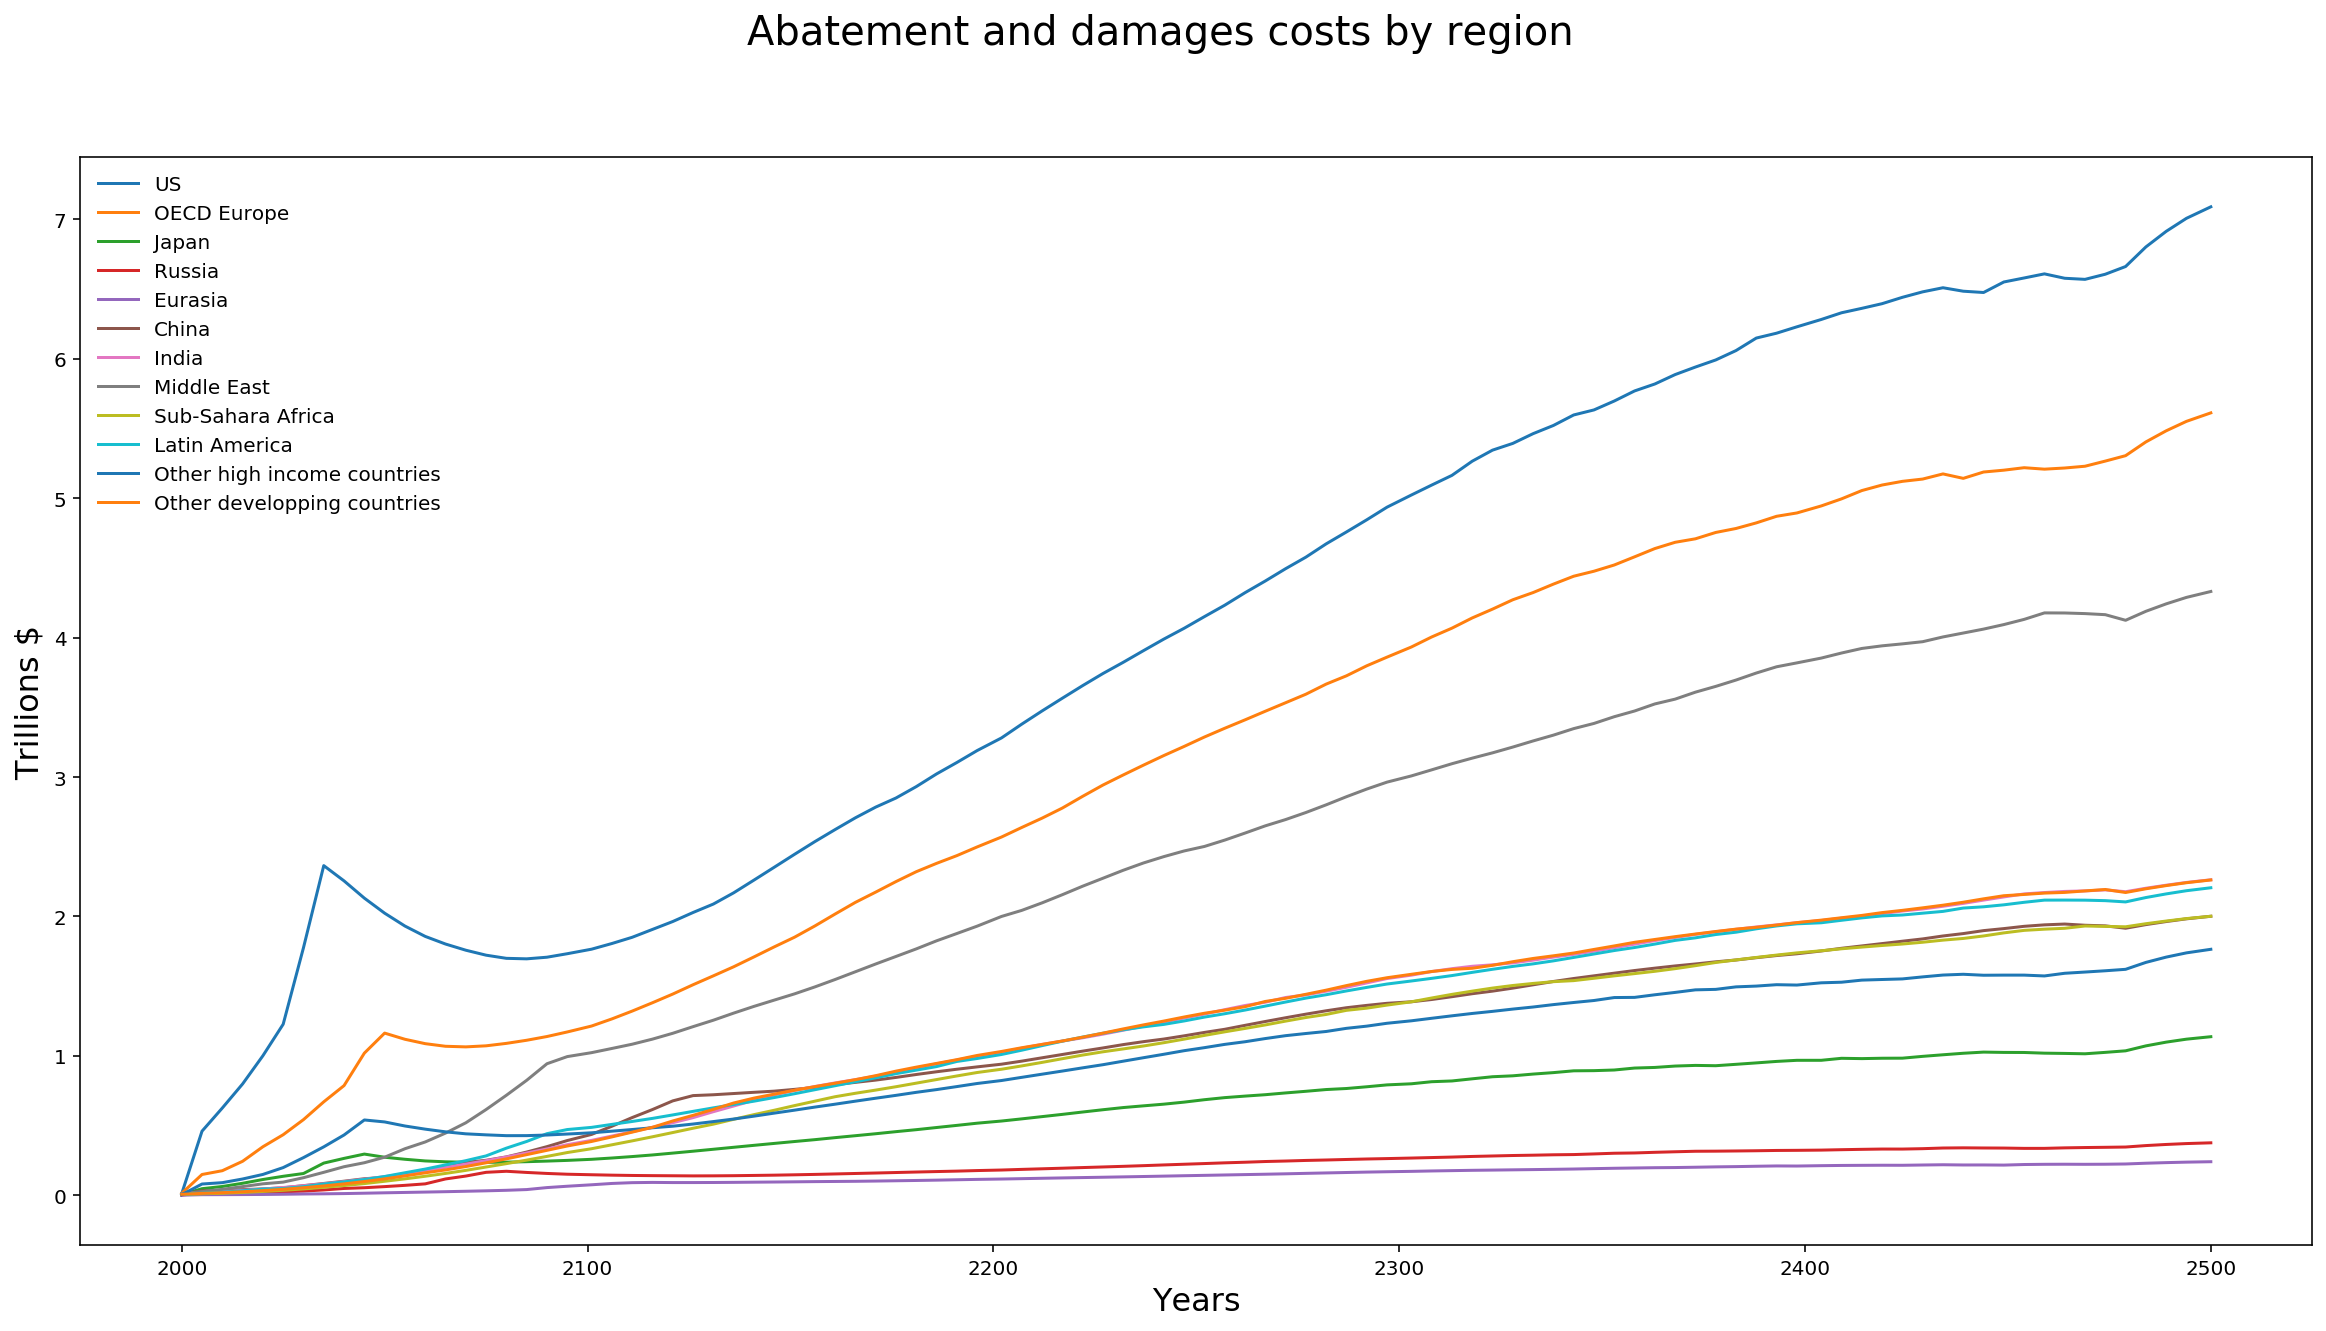

5132.480247974396


In [12]:
if __name__ == '__main__':
    
    start = time.time()
    
    TT = np.linspace(2000, 2500, NT, dtype = np.int32)
    
    # initialization of exogenous variables
    InitializeForcings(forcoth,NT)
    InitializeLabor(l,NT)
    InitializeTFP(al,NT)
    InitializeGrowthSigma(gsig,NT)
    InitializeSigma(sigma,gsig,cost1,NT)
    InitializeCarbonTree(cumetree,NT)
    
    # array of choice variables
    x_start = np.concatenate((MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,
                             MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,
                             MIU_start,S_start,MIU_start,S_start,MIU_start,S_start,MIU_start,S_start))
    bnds = (bnds1+bnds2) * NC # bounds for choice variable, by region
    
    # getting the optimal value of choice variable, using the objective function
    result = opt.minimize(fOBJ, x_start, args=(-1.0,I,K,al,l,WPOP,YGROSS,WYGROSS,sigma,EIND,WEIND,E,CCA,CCATOT,
                                               cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,
                                               ABATECOST,cost1,MCABATE,CPRICE,YNET,WYNET,Y,WY,C,WC,CPC,WCPC,PERIODU,
                                               CEMUTOTPER,RI,NT), 
                          method='SLSQP',bounds = tuple(bnds), tol=0.1, options={'disp': True})
    # setting tolerance to 0.1 or lower yields nice and smooth results
    # if tolerance is 0.01 or lower, it is required to allow for larger number of iterations than 100 (baseline)
    # to do so, add 'maxiter':250 after True in the options
    print(result) # prints utility value
    
    # computing the system of variables from optimal MIU and S
    FOptimal = Optimality(result.x,I,K,al,l,WPOP,YGROSS,WYGROSS,sigma,EIND,WEIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,
                          FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
                          CPRICE,YNET,WYNET,Y,WY,C,WC,CPC,WCPC,PERIODU,CEMUTOTPER,RI,NT)
    
    PlotFigures() # calls the plot function
    end = time.time()
    print(end - start)

### 5. Additional plots for results comparison and overview

#### Temperature increase and emissions in various models

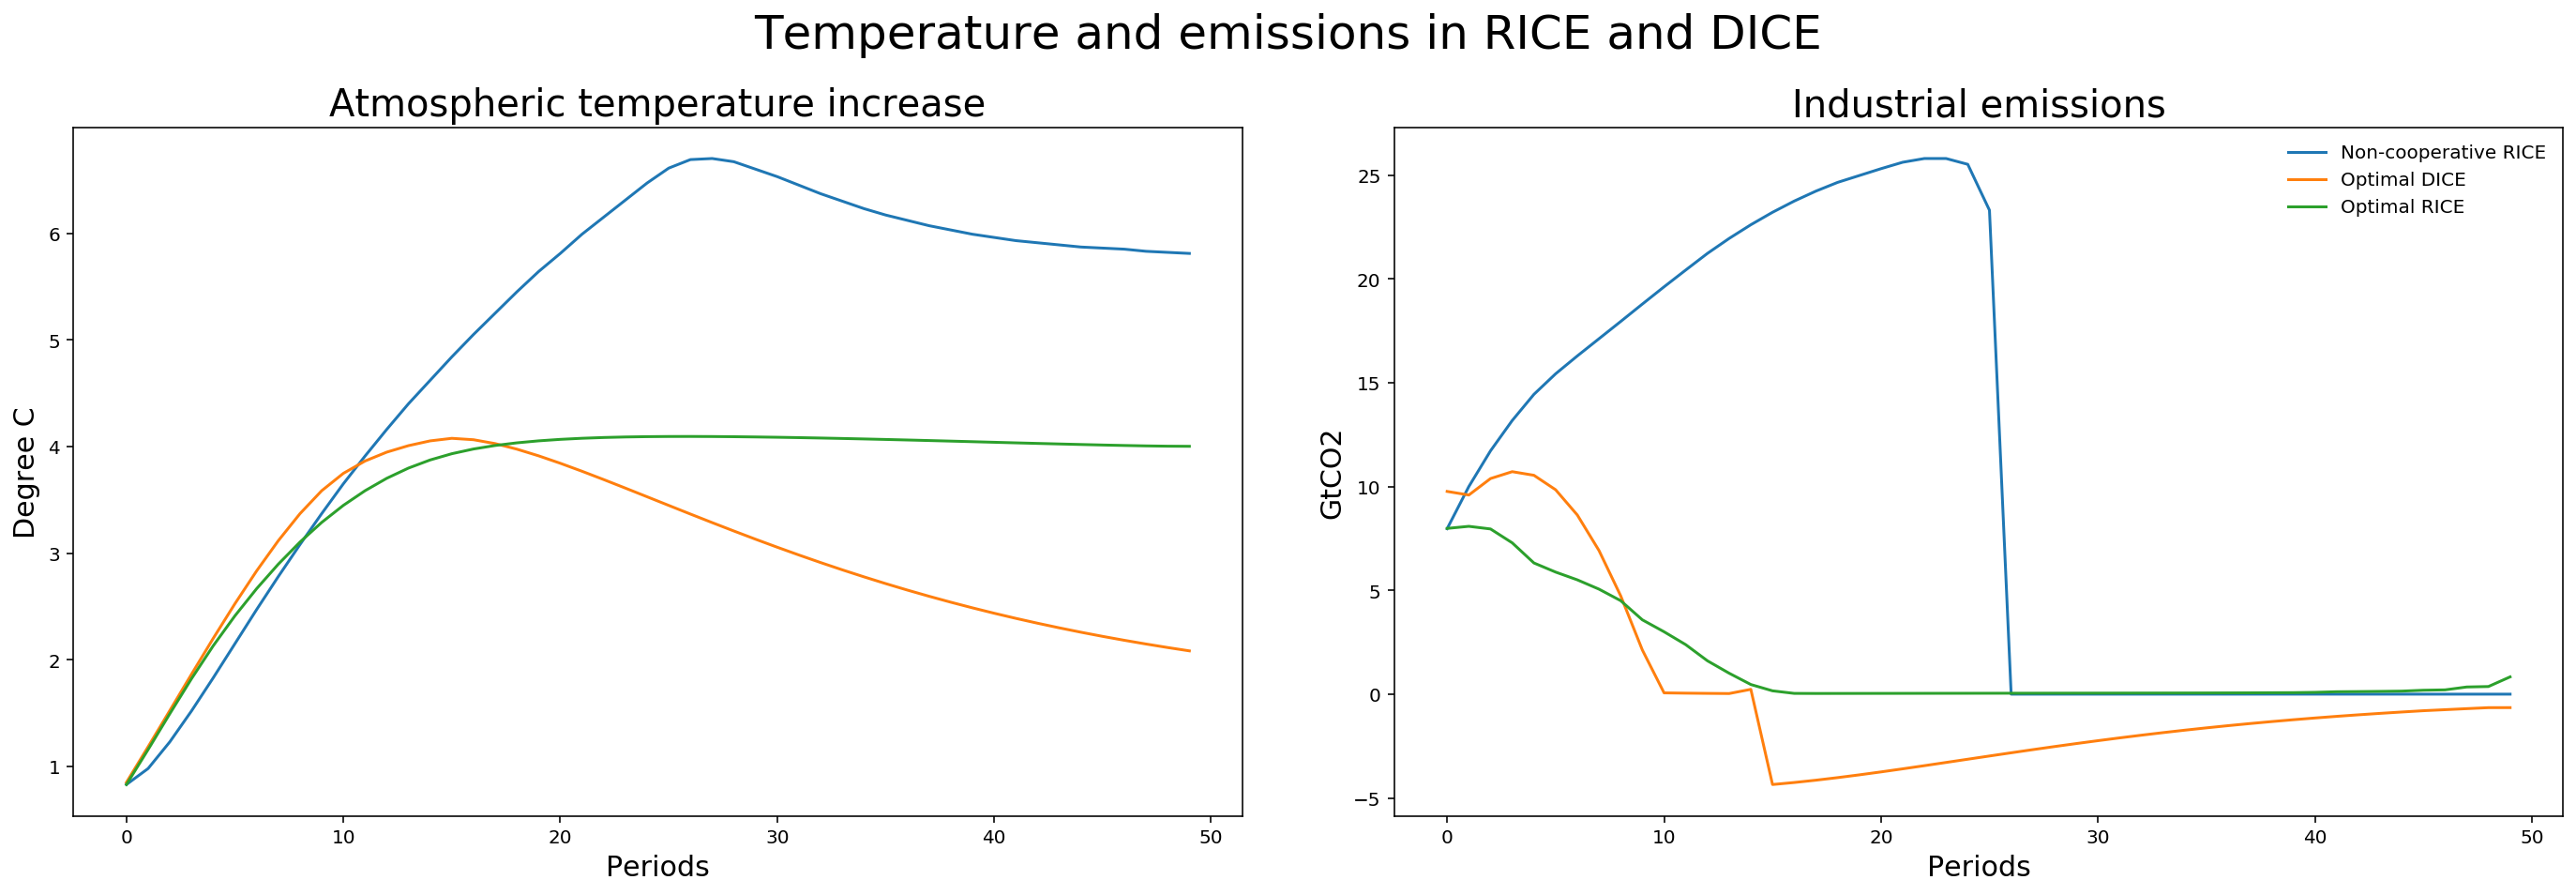

In [144]:
# Temperature data

noncotatm = np.array([0.83, 0.98, 1.23, 1.52, 1.83, 2.15, 2.47, 2.78, 3.08, 3.37, 3.65, 3.91, 4.16, 4.40,
                      4.62, 4.84,5.05, 5.25, 5.45, 5.64, 5.81, 5.99, 6.15, 6.31, 6.47, 6.61, 6.69, 6.70,
                      6.67, 6.60, 6.53, 6.45,6.37, 6.30, 6.23, 6.17, 6.12, 6.07, 6.03, 5.99, 5.96, 5.93,
                      5.91, 5.89, 5.87, 5.86, 5.85, 5.83, 5.82, 5.81]) # non-cooperative, RICE-2010
cotatm = np.array([0.8500, 1.1843, 1.5238, 1.8643, 2.2002, 2.5251, 2.8325, 3.1161, 3.3697, 3.5847, 3.7478, 3.8635,
                   3.9467, 4.0075, 4.0523, 4.0762, 4.0631, 4.0266, 3.9746, 3.9121, 3.8423, 3.7675, 3.6895, 3.6094,
                   3.5283, 3.4470, 3.3660, 3.2860, 3.2073, 3.1302, 3.0551, 2.9821, 2.9113, 2.8430, 2.7772, 2.7139,
                   2.6532, 2.5951, 2.5396, 2.4866, 2.4361, 2.3881, 2.3425, 2.2992, 2.2581, 2.2192, 2.1824, 2.1475,
                   2.1145, 2.0832]) # cooperative, DICE-2016
tatm = np.zeros(50)
for i in range(50):
    tatm[i] = TATM[2*i] # optimal, RICE-2010

# Emissions data
noncoeind = np.array([7.97, 10.00, 11.72, 13.18, 14.44, 15.43, 16.29, 17.12, 17.95, 18.79,
                      19.62, 20.43, 21.23, 21.95, 22.61, 23.21, 23.75, 24.23, 24.65, 24.98, 
                      25.31, 25.62, 25.80, 25.80, 25.52, 23.31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # non-cooperative, RICE-2010
coeind = np.array([35.740, 35.106, 38.009, 39.221, 38.584, 36.036, 31.591, 25.320, 17.337, 7.777, 0.226,
                   0.177, 0.139, 0.109, 0.85, -15.930, -15.574, -15.167, -14.715, -14.226, -13.706, -13.164,
                   -12.607, -12.040, -11.469, -10.900, -10.336, -9.781, -9.238, -8.711, -8.200, -7.708, -7.235, -6.783,
                   -6.352, -5.942, -5.553, -5.185, -4.838, -4.511, -4.203, -3.914, -3.643, -3.388, -3.148, -2.918,
                   -2.737, -2.555, -2.379, -2.374])/3.66 # cooperative, DICE-2016
eind = np.zeros(50)
for i in range(50):
    eind[i] = WEIND[2*i]/3.66 # optimal, RICE-2010

vintage = np.array(["Non-cooperative RICE", "Optimal DICE", "Optimal RICE"])

# Plot

fig, axs = plt.subplots(1,2, figsize=(20, 7))
axs[0].plot(noncotatm)
axs[0].plot(cotatm)
axs[0].plot(tatm)
axs[0].set_title('Atmospheric temperature increase', fontsize=20)
axs[0].set_ylabel('Degree C', fontsize=15)
axs[1].plot(noncoeind)
axs[1].plot(coeind)
axs[1].plot(eind)
axs[1].set_title('Industrial emissions', fontsize=20)
fig.suptitle('Temperature and emissions in RICE and DICE', fontsize=25, y = 1.0)
axs[1].set_ylabel('GtCO2', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('Periods', fontsize=15)
    
plt.legend(vintage, frameon = False)
plt.tight_layout(4)
# plt.savefig('vintage.png') # to save the graph
plt.show()

#### Summary graph of main variables

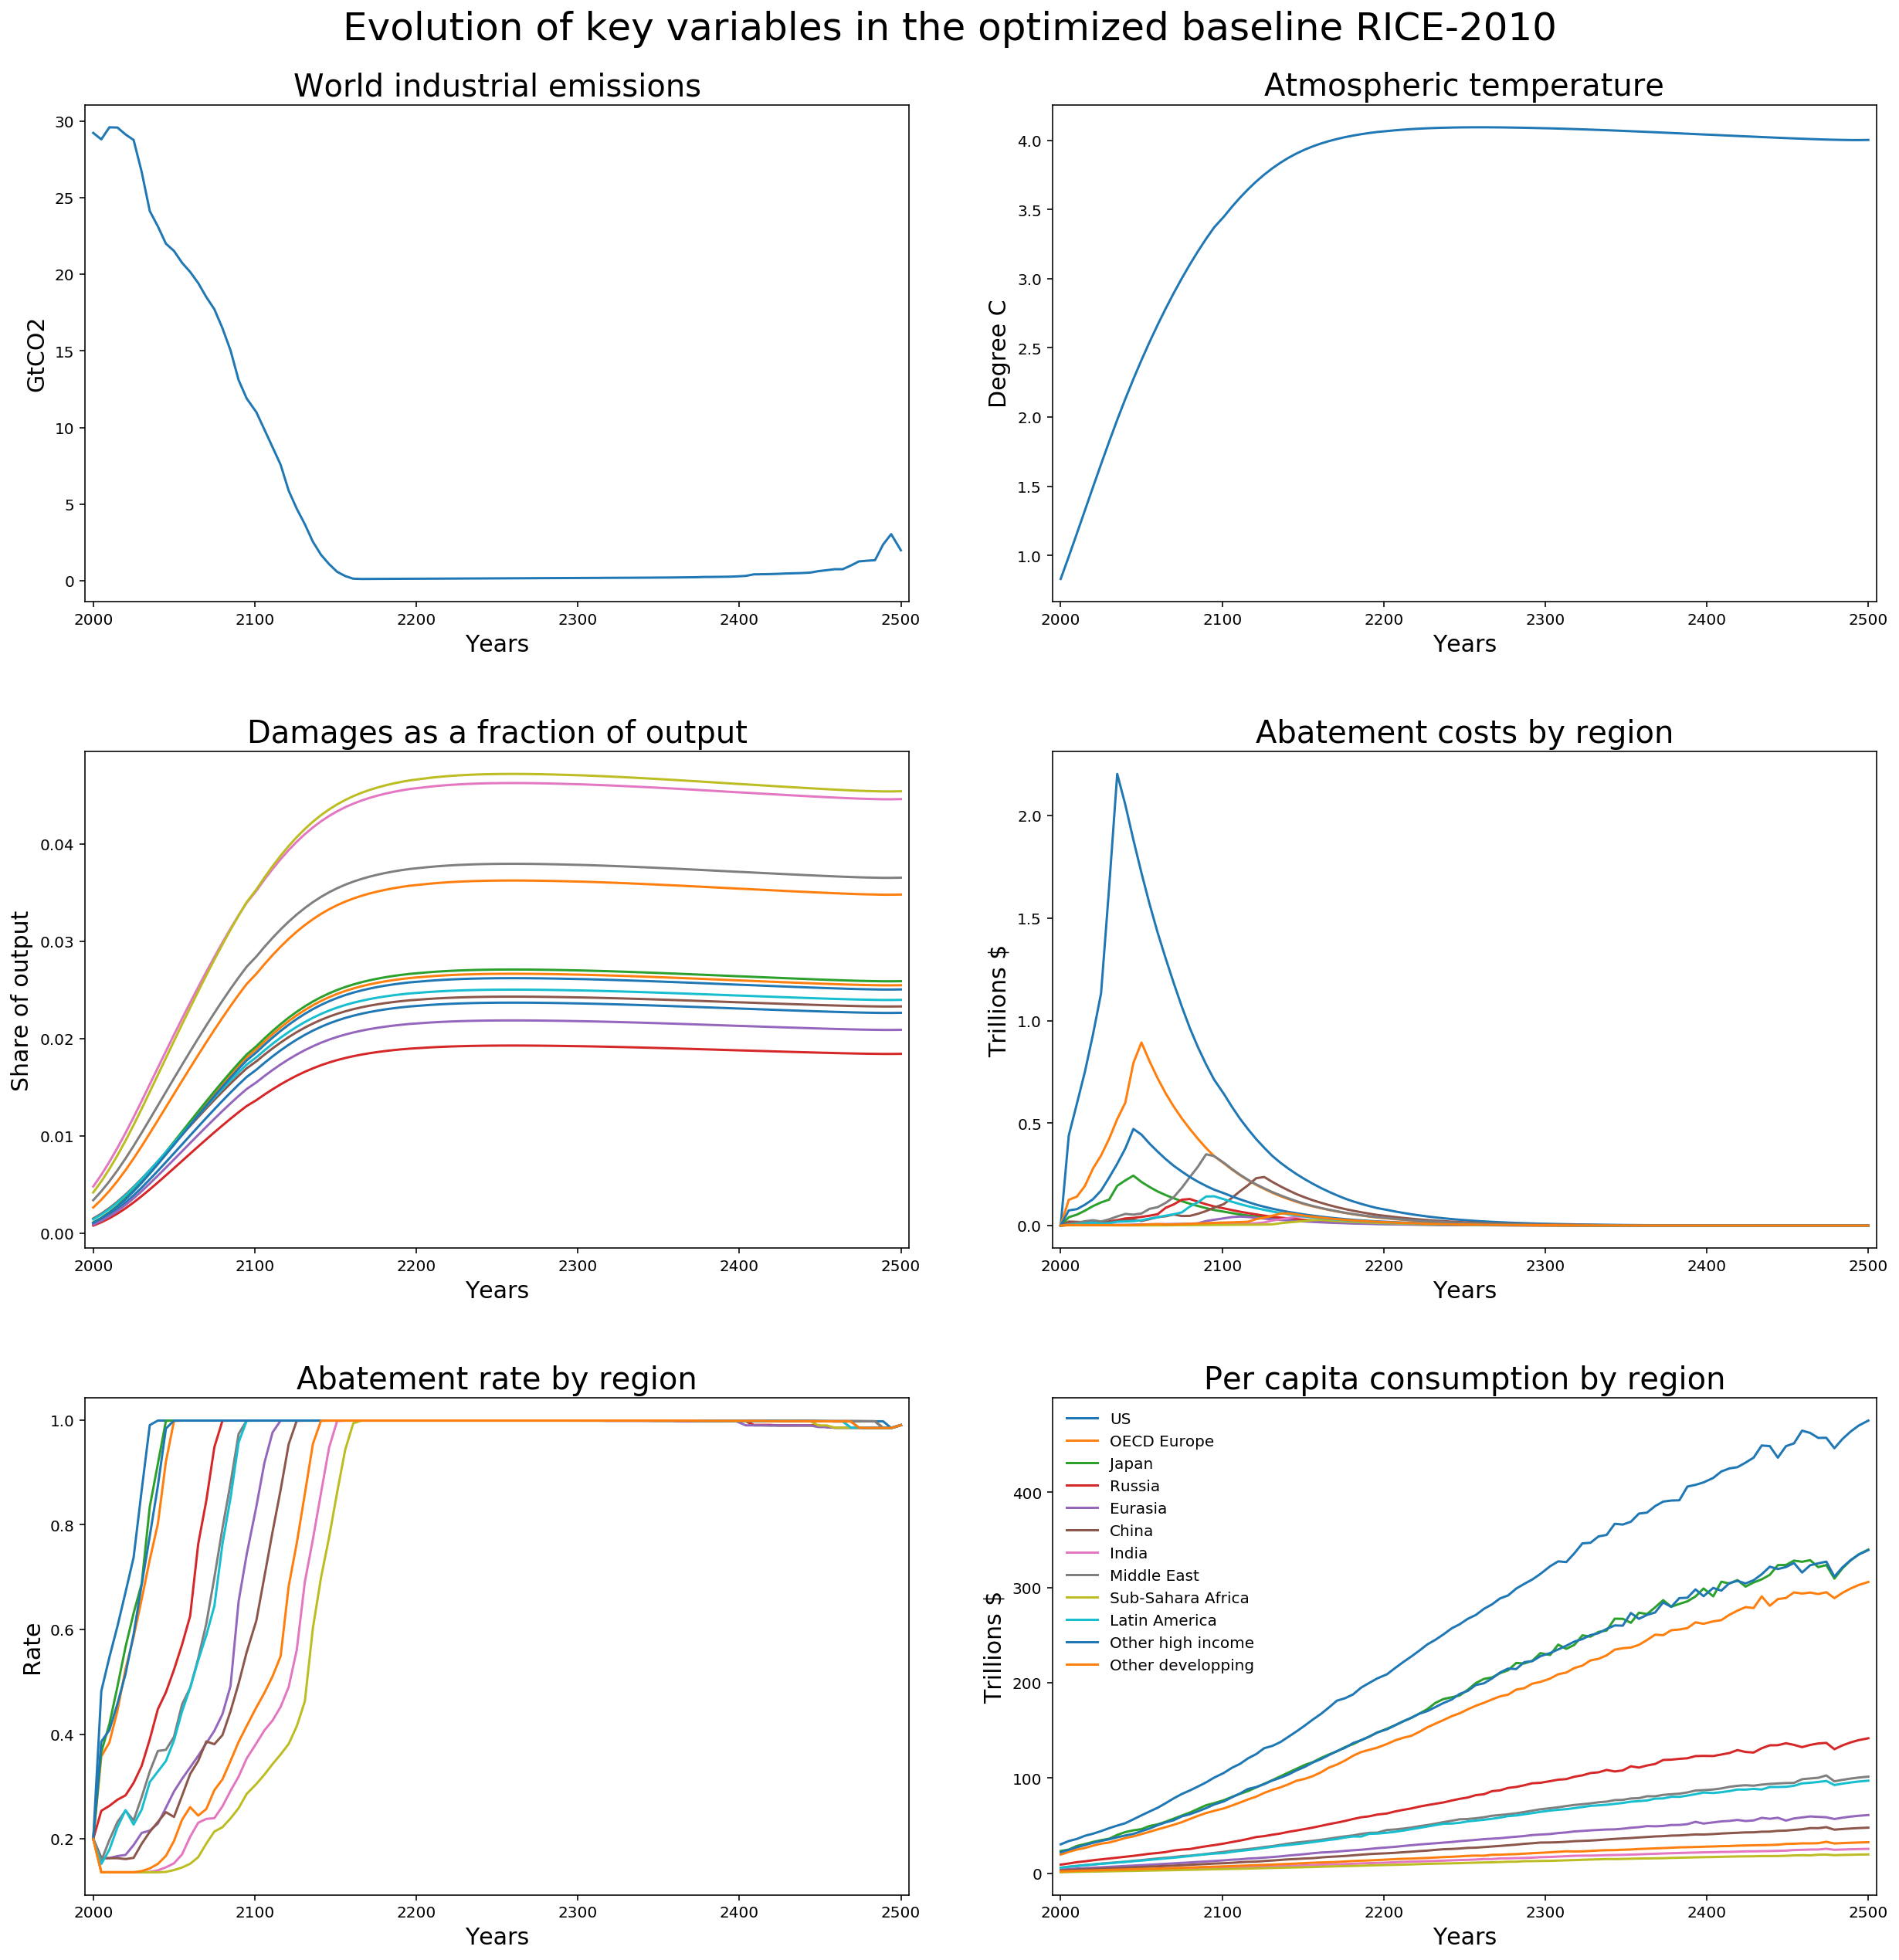

In [146]:
fig, axs = plt.subplots(3,2,figsize=(18, 18))
axs[0, 0].plot(TT, WEIND)
axs[0, 0].set_title('World industrial emissions', fontsize=20)
axs[0, 0].set_ylabel('GtCO2', fontsize=15)
axs[0, 1].plot(TT, TATM)
axs[0, 1].set_title('Atmospheric temperature', fontsize=20)
axs[0, 1].set_ylabel('Degree C', fontsize=15)
axs[1, 0].plot(TT, DAMFRAC)
axs[1, 0].set_title('Damages as a fraction of output', fontsize=20)
axs[1, 0].set_ylabel('Share of output', fontsize=15)
axs[1, 1].plot(TT, ABATECOST)
axs[1, 1].set_title('Abatement costs by region', fontsize=20)
axs[1, 1].set_ylabel('Trillions $', fontsize=15)
axs[2, 0].plot(TT, ABRATE)
axs[2, 0].set_title('Abatement rate by region', fontsize=20)
axs[2, 0].set_ylabel('Rate', fontsize=15)
axs[2, 1].plot(TT, CPC)
axs[2, 1].set_title('Per capita consumption by region', fontsize=20)
axs[2, 1].set_ylabel('Trillions $', fontsize=15)
fig.suptitle('Evolution of key variables in the optimized baseline RICE-2010', fontsize=25, y = 1.0)

for ax in axs.flat:
    ax.set_xlabel('Years', fontsize=15)
    ax.set_xlim(1995,2505)
    
plt.legend(COUNTRIES, frameon = False)
plt.tight_layout(4)
# plt.savefig('baseline_final.png', dpi = 150) # to save graph
plt.show()